In this notebook, we generate synthetic fish pairs that closely resemble the empirical data. We construct the data assuming the following possible interaction states:

0. in-phase swimming
1. out-of-phase swimming
2. instantaneous response of partner to focal movement
3. both fish swim independently
4. focal fish swims independently while partner is mostly unresponsive
5. partner swims independently while focal fish is mostly unresponsive

We then fit a constrained linear-model HMM (cLM-HMM) to the synthetic data and uncover the same three states observed in the empirical data.

This notebook requires the dataframe from https://data.mendeley.com/datasets/n795jd566x/1

# Background: Lognormal distributions
____

## Univariate distribution:

Let $X$ and $Y = \ln{X}$ be continuous random variables that are log-normally and normally distributed, respectively. The probability density function (PDF) is given by:
$$
p(x) = \frac{1}{x \sigma_{Y} \sqrt{2\pi} } \exp\left[-\frac{(\ln(x) - \mu_{Y})^2}{2\sigma_{Y}^2} \right]
$$
where the mean $\mu_{Y}$ and standard deviation $\sigma_{Y}$ are defined as:
$$
\sigma_{Y}^2 = \ln\left(1 + \dfrac{\sigma_{X}^2}{\mu_{X}^2}\right)
$$
$$
\mu_{Y} = \ln\left(\dfrac{\mu_{X}^2}{\sqrt{\mu_{X}^2 + \sigma_{X}^2}}\right) = \ln(\mu_{X}) - \dfrac{1}{2}\sigma_{Y}^2
$$
and $\mu_{X}$ and $\sigma_{X}$ are the mean and standard deviation of $X$.

## Bivariate distribution:

Now consider two continuous random variables $X_1$ and $X_2$ that are lognormally distributed. The joint distribution is represented by a bivariate lognormal distribution whose PDF is given by:
$$
f(x_1, x_2) = \frac{1}{2\pi x_1 x_2 \sigma_{Y_1} \sigma_{Y_2} \sqrt{1 - \rho^2}} \exp\left[-\frac{1}{2(1 - \rho^2)} \left( \frac{(\ln(x_1) - \mu_{Y_1})^2}{\sigma_{Y_1}^2} + \frac{(\ln(x_2) - \mu_{Y_2})^2}{\sigma_{Y_2}^2} - 2\rho \frac{(\ln(x_1) - \mu_{Y_1})(\ln(x_2) - \mu_{Y_1})}{\sigma_{Y_1} \sigma_{Y_2}} \right)\right]
$$
where $\mu_{Y_i}$ and $\sigma_{Y_i}$ are the mean and standard deviation of $Y_i = \ln X_i$ for $i=1,2$ as defined above, and the correlation coefficient $\rho = \dfrac{\text{Cov}(Y_1,Y_2)}{\sigma_{Y_1}\sigma_{Y_2}}$

## Bivariate conditional distribution

The conditional log-normal probability distribution is given by:
$$
p(x_2|x_1) = \frac{1}{x_2 \sigma_{Y_2|Y_1} \sqrt{2\pi}}\exp\left[-\frac{1}{2 \sigma_{Y_2|Y_1}^2} \left(\ln{x_2} - \mu_{Y_2|Y_1} \right)^2\right]
$$
where the conditional mean $\mu_{Y_2|Y_1}$ and variance $\sigma_{Y_2|Y_1}^2$ are:
$$
\mu_{Y_2|Y_1} \equiv \mu_{Y_2} + \rho \dfrac{\sigma_{Y_2}}{\sigma_{Y_1}}\left(\ln x_1 - \mu_{Y_1}\right)
$$
$$
\sigma_{Y_2|Y_1}^2 \equiv \sigma_{Y_2}^2(1-\rho^2)
$$

## Multivariate conditional distribution

Now consider multiple log-normally distributed random variables $X_i$ and let $\mathbf{Y}_i = \ln X_i$ for $i=1,\dots,D$ represent the corresponding normally distributed variables.

The PDF for the joint distribution of $\mathbf{x} = [x_1, \dots, x_D]^\top$ follows a multivariate lognormal distribution: 
$$
f(\mathbf{x}) = \frac{1}{(2\pi)^{D/2} |\mathbf{\Sigma}|^{1/2} \prod_{i=1}^{D} x_i} \exp\left[-\frac{1}{2} (\mathbf{y} - \boldsymbol{\mu}_Y)^\top \mathbf{\Sigma}^{-1} (\mathbf{y} - \boldsymbol{\mu}_Y) \right]
$$ 
where $\mathbf{y} = \ln \mathbf{x}$ and
the mean vector $\boldsymbol{\mu}_Y = [\mu_{Y_1}, \mu_{Y_2}, \dots, \mu_{Y_D}]^\top$. The covariance matrix $\mathbf{\Sigma}$ is defined by:
$$
\mathbf{\Sigma} = \begin{pmatrix} 
\sigma_{Y_1}^2 & \rho_{12} \sigma_{Y_1} \sigma_{Y_2} & \cdots & \rho_{1D} \sigma_{Y_1} \sigma_{Y_D} \\
\rho_{21} \sigma_{Y_2} \sigma_{Y_1} & \sigma_{Y_2}^2 & \cdots & \rho_{2D} \sigma_{Y_2} \sigma_{Y_D} \\
\vdots & \vdots & \ddots & \vdots \\
\rho_{D1} \sigma_{Y_D} \sigma_{Y_1} & \rho_{D2} \sigma_{Y_D} \sigma_{Y_2} & \cdots & \sigma_{Y_D}^2 
\end{pmatrix}
$$
where $\rho_{ij} = \dfrac{\text{Cov}(Y_i, Y_j)}{\sigma_{Y_i} \sigma_{Y_j}}$ is the correlation coefficient between the variables $Y_i$ and $Y_j$, and $\sigma_{Y_i}$ is the standard deviation of $Y_i$.


Next, we calculate the conditional distribution $p(\mathbf{x}_{a} | \mathbf{x}_b)$, where we split the components such that $\mathbf{x} = [\mathbf{x}_a, \mathbf{x}_b]^\top$. For the purposes off this notebook, we are interested in the case where $\mathbf{x}_a = [x_1]$ and $\mathbf{x}_b = [x_2,\dots,x_D]^\top$. Additionally, we assume that each $\mathbf{X}_i$ represents the same random variable with the $i$ index denoting the draw from the lagged value at time point $t+(1-i)$, but the correlation coeff between lags differs. Therefore $\sigma_Y \equiv  \sigma_{Y_i}$ and $\rho_{ij} = \rho_{i+1,j+1}$ for all $i,j$. This results in a simplified Toeplitz covariance matrix 
$$
\mathbf{\Sigma} = 
\sigma_Y^2
\begin{pmatrix} 
1 & \rho_{12} & \cdots & \rho_{1D} \\
\rho_{12} & 1 & \cdots & \rho_{1,D-1} \\
\vdots & \vdots & \ddots & \vdots \\
\rho_{1D} & \rho_{1,D-1} & \cdots & 1 
\end{pmatrix}
\equiv \sigma_Y^2 \mathbf{R}
$$
where $\mathbf{R}$ is the correlation matrix. We can express the conditional distribution PDF as:
$$
p(x_1 | x_2,\dots,x_D) = \frac{1}{x_1 \sigma_{Y_{a|b}} \sqrt{2\pi} } \exp\left[-\frac{(\ln(x_1) - \mu_{Y_{a|b}})^2}{2\sigma_{Y_{a|b}}^2} \right]
$$

where the conditional mean $\mu_{Y_a|Y_b}$ and variance $\sigma_{Y_a|Y_b}^2$ are:
$$
\mu_{Y_a|Y_b} \equiv \mu_{Y_1} + \boldsymbol{\rho}^\top \mathbf{R}_{1:D-1}^{-1} \dfrac{\sigma_{Y_2}}{\sigma_{Y_1}}\left(\ln \mathbf{x}_b - \boldsymbol{\mu}_{Y_b}\right)
$$
$$
\sigma_{Y_a|Y_b}^2 \equiv \sigma_{Y}^2 - \boldsymbol{\rho}^\top \mathbf{R}_{1:D-1}^{-1} \boldsymbol{\rho}
$$
where we defined
$$
\boldsymbol{\rho} = [\rho_{12},\dots,\rho_{1D}]^\top
$$
$$
\mathbf{R}_{1:D-1} = 
\begin{pmatrix} 
1 & \rho_{12} & \cdots & \rho_{1,D-1} \\
\rho_{12} & 1 & \cdots & \rho_{1,D-2} \\
\vdots & \vdots & \ddots & \vdots \\
\rho_{1,D-1} & \rho_{1,D-2} & \cdots & 1 
\end{pmatrix}
$$

## Fitting distributions with `scipy`

Note that `scipy.stats.lognorm.pdf` uses the standardized distribution. For example, passing `scipy.stats.lognorm.pdf(x,s)`
$$
f(x,s) = \dfrac{1}{sx\sqrt{2\pi}} \exp \left[ -\dfrac{\ln(x)^2}{2s^2}\right]
$$
To get the form we previously defined, we must pass more variables using `scipy.stats.lognorm.pdf(x,s,loc,scale)` where 
$$
\sigma_{Y} \equiv s
$$
$$
\mu_{Y} \equiv \ln{\text{scale}}
$$
and $m \equiv \text{loc}$ shifts the distribution. This gives us the PDF in a familiar form:
$$
f(x,s,\text{loc},\text{scale}) = \dfrac{1}{(x-m)\sigma_{Y}\sqrt{2\pi}} \exp \left[ -\dfrac{(\ln{(x-m)} - \mu_{Y})^2}{2\sigma_{Y}^2}\right]
$$


# __Step 1__: Import libraries and load data
___

## 1a. Optionally restrict notebook to run on subset of CPUs

While Dynamax is capable of utilizing GPUs to efficiently run model fits, we can restrict this notebook to run on CPUs. First check how many cores are available. Then select the cores you want to use to run this notebook and restrict computations to this subset.

In [1]:
import psutil

max_workers = psutil.cpu_count(logical=True)
print(f"Available cores: {max_workers}")

Available cores: 64


In [2]:
# choose subset of cores to utilize 
cpu_list = list(range(0,32))

assert len(cpu_list) < max_workers

In [3]:
import os

def set_cpu_affinity_for_process(p, cpu_list):
    """Sets the CPU affinity for a process."""
    try:
        p.cpu_affinity(cpu_list)
    except psutil.AccessDenied:
        print(f"Could not set CPU affinity for process {p.pid}")

# Get the current process
main_process = psutil.Process(os.getpid())

# Set CPU affinity for the main process
set_cpu_affinity_for_process(main_process, cpu_list)

# Set CPU affinity for all child processes
for child in main_process.children(recursive=True):
    set_cpu_affinity_for_process(child, cpu_list)

print(f"CPU affinity set to: {main_process.cpu_affinity()} for the main process")

CPU affinity set to: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] for the main process


If you want to use GPUs anyway, you can change the following code block.

In [4]:
# optionally utilize GPUs and specify fraction of memory prelocated for dynamax
use_GPUs = False
preallocate_mem = True if use_GPUs else None
mem_frac = 0.5 if preallocate_mem else None

if use_GPUs: 
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = str(preallocate_mem)  # optionally preallocate memory on GPU
    if preallocate_mem:
        os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = str(mem_frac)    # fraction of memory to preallocate
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""  # hide available GPU devices so code will run on CPUs
    os.environ["JAX_PLATFORMS"] = "cpu"      # force JAX to use CPU backend

## 1b. Import libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

from itertools import count
from scipy import signal, stats, linalg
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import ImageGrid
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import KFold

# import libraries for model fits
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax import config
from dynamax.utils.utils import pytree_slice
from dynamax.hidden_markov_model import ConstrainedLinearRegressionSharedSphericalGaussianHMM

# display CUDA compatible GPUs available (or CPU if there are none)
print("Visible devices: {}".format(jax.devices()))

Visible devices: [CpuDevice(id=0)]


## 1c. Load data

This notebook is designed to work with either the final analyzed dataframe `coupled_analyzed_observed_df` that will be uploaded to Mendelev, or it works with the dataframe that we get out from the pre-processing notebooks `obs_frame_df`.

In [6]:
use_analyzed_df = True

# define file path and load dataframe
path = "/path/to/dataframe/..."

analyzed_df_name = "coupled_analyzed_observed_df.feather"
df = pd.read_feather(path + analyzed_df_name)

# keep only frames with valid input/output
valid_IO_sel = (df["valid_IO"]==True)
df = df[valid_IO_sel]


Analyzed observed df size: 376.65 MB


In [7]:
# define FPS and resolution (pixels per mm) of recordings
FPS = 60
pix_mm = 18.9

num_states = 3

c_labels = ["Light","Dark","Neo","Neo Dark"]
n_classes = len(c_labels)

# __Step 2__: Get active and inactive durations from empirical data
____

We approximate the speeds of our zebrafish as binary bout sequences. Each pulse (or bout) is composed of an active and inactive sequence. Lets first obtain these quantities for each pulse in the empirical data so that we can look at the probability distributions of said quantities.

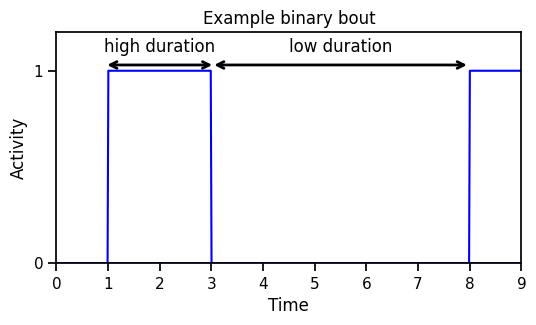

In [8]:
# plot demonstration pulse and label hi and low activity
fig = plt.figure(figsize=(6,3))
t = np.linspace(0, 15, 1000)
pulse1, pulse2 = np.where((t >= 1) & (t <= 3), 1, 0), np.where((t >= 8) & (t <= 14), 1, 0)
plt.plot(t, pulse1, 'b', t, pulse2, 'b')
plt.annotate('', xy=(0.93, 1.03), xytext=(3.07, 1.03), arrowprops=dict(arrowstyle='<->', lw=2, color='k'))
plt.text(2, 1.1, 'high duration', fontsize=12, ha='center', color='k')
plt.annotate('', xy=(3, 1.03), xytext=(8, 1.03), arrowprops=dict(arrowstyle='<->', lw=2, color='k'))
plt.text(5.5, 1.1, 'low duration', fontsize=12, ha='center', color='k')
plt.xlabel("Time"); plt.ylabel("Activity"); plt.yticks([0, 1]); plt.ylim(-0, 1.2); plt.xlim(0, 9)
plt.title("Example binary bout")
plt.show()


## 2a. Identify start frames of hi/low sequences and package in dataframe

Reusing the same code from the last section in the analysis notebook for plotting PRCs. 

In [9]:
def get_repeated_subsequences_and_frames(sequence, frames):
    """
    Extracts repeated subsequences and their corresponding frame numbers.
    For example, the sequence [0,0,0,1,2,2,1] --> [[0,0,0],[1],[2,2],[1]].

    Parameters:
    - sequence: list or np.array, the sequence of elements.
    - frames: list or np.array, the corresponding frame numbers.

    Returns:
    - subsequences: list of lists, subsequences of repeated elements.
    - frame_numbers: list of lists, corresponding frame numbers for each subsequence.
    """
    subsequences = []
    frame_numbers = []

    current_subseq = [sequence[0]]
    current_frames = [frames[0]]

    for i in range(1, len(sequence)):
        if sequence[i] == sequence[i - 1]:
            current_subseq.append(sequence[i])
            current_frames.append(frames[i])
        else:
            subsequences.append(current_subseq)
            frame_numbers.append(current_frames)
            current_subseq = [sequence[i]]
            current_frames = [frames[i]]

    subsequences.append(current_subseq)
    frame_numbers.append(current_frames)

    return subsequences, frame_numbers


def analyze_subsequences(sequence, frames):
    """
    Takes binary pulse trains of fish activity with corresponding frames. Pulses
    are composed of a active period (1s) followed by an inactive period (0s). We
    truncate leading 0s and the final incomplete period, then classify subsequences 
    within the pulse train as active or inactive and record the start frames.

    Parameters:
    - sequence (list or np.array): 1D sequence of elements.
    - frames   (list or np.array): Corresponding frame numbers.

    Returns:
    - low_start_frames (list): Start frames for inactive sequences.
    - low_durations    (list): Durations for inactive sequences
    - hi_start_frames  (list): Start frames for active sequences.
    - hi_durations     (list): Durations for active sequences.
    """

    # ensure sequence is array of shape (N,)
    sequence = np.array(sequence)
    assert np.array(sequence).ndim == 1

    # truncate leading 0s (inactive period)
    first_one_idx = np.argmax(sequence == 1)
    sequence = sequence[first_one_idx:]
    frames = frames[first_one_idx:]

    # remove last inactive period
    if sequence[-1] == 0:
        last_one_idx = len(sequence) - 1 - np.argmax(sequence[::-1] == 1)
        sequence = sequence[:last_one_idx + 1]
        frames = frames[:last_one_idx + 1]

    # remove last active sequence to ensure last period ends on completed inactive sequence
    last_zero_idx = len(sequence) - 1 - np.argmax(sequence[::-1] == 0)
    sequence = sequence[:last_zero_idx + 1]
    frames = frames[:last_zero_idx + 1]

    # get repeated subsequences and frames
    subsequences, frame_numbers = get_repeated_subsequences_and_frames(sequence, frames)

    # initialize lists for start frames and durations
    low_start_frames = []
    low_durations = []
    hi_start_frames = []
    hi_durations = []

    # iterate over subsequences to calculate start frames and durations
    for subseq, frames in zip(subsequences, frame_numbers):

        start_frame = frames[0]
        duration = len(subseq)

        if subseq[0] == 0:  # inactive sequence
            low_start_frames.append(start_frame)
            low_durations.append(duration)

        elif subseq[0] == 1:  # active sequence
            hi_start_frames.append(start_frame)
            hi_durations.append(duration)

    return low_start_frames, low_durations, hi_start_frames, hi_durations

In [10]:
def get_prc_df(df, focal_hi_frames, partner_hi_frames, focal_low_frames, partner_low_frames, 
               focal_hi_durs, partner_hi_durs, focal_low_durs, partner_low_durs,
               state_type="local_thresh_state", verbose=False):
    """
    Construct data frame with the durations of active & inactive periods and the frames
    in which they begin for both the focal and partner fish. 
    """

    # init lists
    data = []

    # record number of bouts focal fish initiates that partner does not respond to
    focal_bouts_w_no_response = 0

    # get num of focal bouts
    n_bouts = len(focal_hi_frames)

    # get frames and states
    df_frames = df["frame"].values
    df_states = df[state_type].values

    for i in range(n_bouts):
        focal_start = focal_hi_frames[i]
        focal_period_end = focal_hi_frames[i + 1] if i < n_bouts - 1 else np.inf

        valid_partner_bouts = [
                    (frame, partner_low_frames[idx], partner_hi_durs[idx], partner_low_durs[idx])
                for idx, frame in enumerate(partner_hi_frames)
            if focal_start <= frame < focal_period_end  # include 0-lag response
        ]

        if not valid_partner_bouts:
            #print(f"No valid partner bouts found for focal bout at frame {focal_start}.")
            focal_bouts_w_no_response += 1

        for j, (partner_hi_start, partner_low_start, p_hi_dur, p_low_dur) in enumerate(valid_partner_bouts):

            response_lag = partner_hi_start - focal_start
            is_first_response = (j == 0)

            focal_lo_start  = focal_low_frames[i] if i < len(focal_low_frames) else np.nan
            f_hi_dur = focal_hi_durs[i] if i < len(focal_hi_durs) else np.nan
            f_lo_dur = focal_low_durs[i] if i < len(focal_low_durs) else np.nan

            # select frames between start of focal fish active sequence and the 
            # end of the responding partners active sequence
            f_sel = (df_frames >= focal_start) & (df_frames <= (partner_hi_start + p_hi_dur))
            states = df_states[f_sel]

            # determine the state
            unique_states = np.unique(states)
            state = unique_states[0] if len(unique_states) == 1 else np.nan

            # get focal period
            f_period = f_hi_dur + f_lo_dur

            data.append([
                focal_start,
                f_hi_dur,
                focal_lo_start,
                f_lo_dur,
                partner_hi_start,
                p_hi_dur,
                partner_low_start,
                p_low_dur,
                response_lag,
                f_period,
                state,
                is_first_response,
            ])

    # create dataframe
    response_lags_df = pd.DataFrame(data, columns=[
        "focal_hi_start_frame", 
        "focal_hi_duration", 
        "focal_low_start_frame", 
        "focal_low_duration", 
        "partner_hi_start_frame", 
        "partner_hi_duration", 
        "partner_low_start_frame", 
        "partner_low_duration", 
        "partner_response_lag", 
        "focal_period",
        "state",
        "first_response",
    ])

    if verbose:
        print("partner did not respond to {} out of {} focal periods".format(focal_bouts_w_no_response, n_bouts))

    return response_lags_df


def get_prc_df_by_group_class(
        bdf, focal_fish_num,
        f_low_frames_by_class_group, f_hi_frames_by_class_group, f_low_durations_by_class_group, f_hi_durations_by_class_group, 
        p_low_frames_by_class_group, p_hi_frames_by_class_group, p_low_durations_by_class_group, p_hi_durations_by_class_group,
        state_type="local_thresh_state"):
    
    df_list = []
    
    # loop through conditions
    for c, condition in enumerate(bdf["class"].unique()):
        c_sel = (bdf["class"] == condition)

        # loop through groups within condition
        for g, group in enumerate(bdf[c_sel]["group"].unique()):

            # select group
            g_sel = (bdf["group"] == group)
            
            # focal fish data
            f_low_frms_c_g = f_low_frames_by_class_group[c][g]
            f_low_durs_c_g = f_low_durations_by_class_group[c][g]
            f_hi_frms_c_g = f_hi_frames_by_class_group[c][g]
            f_hi_durs_c_g = f_hi_durations_by_class_group[c][g]

            # partner fish data
            p_low_frms_c_g = p_low_frames_by_class_group[c][g]
            p_low_durs_c_g = p_low_durations_by_class_group[c][g]
            p_hi_frms_c_g = p_hi_frames_by_class_group[c][g]
            p_hi_durs_c_g = p_hi_durations_by_class_group[c][g]

            # make df for group
            g_df = get_prc_df(
                bdf[g_sel], 
                f_hi_frms_c_g, p_hi_frms_c_g, f_low_frms_c_g, p_low_frms_c_g,
                f_hi_durs_c_g, p_hi_durs_c_g, f_low_durs_c_g, p_low_durs_c_g,
                state_type
            )

            # add columns: focal fish number, group, condition
            g_df["focal_fish"] = focal_fish_num
            g_df["group"] = group
            g_df["class"] = condition

            # append to list
            df_list.append(g_df)

    return pd.concat(df_list)

In [11]:
# get list of conditions
cs = df["class"].unique().tolist()

# init lists to store start frame and durations of active sequences
f0_hi_start_frames_by_class_group = [[] for _ in cs]
f0_hi_durs_by_class_group = [[] for _ in cs]
f1_hi_start_frames_by_class_group = [[] for _ in cs]
f1_hi_durs_by_class_group = [[] for _ in cs]

# init lists to store start frame and durations of inactive sequences
f0_lo_start_frames_by_class_group = [[] for _ in cs]
f0_lo_durs_by_class_group = [[] for _ in cs]
f1_lo_start_frames_by_class_group = [[] for _ in cs]
f1_lo_durs_by_class_group = [[] for _ in cs]

# loop through groups
for g in df["group"].unique():

    # select group and get condition
    g_sel = (df["group"] == g)
    cond = df[g_sel]["class"].unique()[0]

    # get frames and binary bout sequences for each fish (only for valid IO frames)
    frames = df[g_sel]["frame"].tolist()
    f0_bout_seq = df[g_sel]["f0_bout_seq"].to_list()
    f1_bout_seq = df[g_sel]["f1_bout_seq"].to_list()

    # get active and inactive sequence start frames and durations
    f0_low_start_frames, f0_low_durations, f0_hi_start_frames, f0_hi_durations = analyze_subsequences(f0_bout_seq, frames)
    f1_low_start_frames, f1_low_durations, f1_hi_start_frames, f1_hi_durations = analyze_subsequences(f1_bout_seq, frames)

    # append to lists
    f0_hi_start_frames_by_class_group[cond].append(f0_hi_start_frames)
    f1_hi_start_frames_by_class_group[cond].append(f1_hi_start_frames)
    f0_hi_durs_by_class_group[cond].append(f0_hi_durations)
    f1_hi_durs_by_class_group[cond].append(f1_hi_durations)

    f0_lo_start_frames_by_class_group[cond].append(f0_low_start_frames)
    f1_lo_start_frames_by_class_group[cond].append(f1_low_start_frames)
    f0_lo_durs_by_class_group[cond].append(f0_low_durations)
    f1_lo_durs_by_class_group[cond].append(f1_low_durations)

In [12]:
# choose "local_thresh_state" for thresheld states, "local_states" for viterbi states
state_type = "local_thresh_state"

# get dataframe with fish 0 as the focal fish
f0_focal_PRC_df = get_prc_df_by_group_class(
    df, 0,
    f0_lo_start_frames_by_class_group, f0_hi_start_frames_by_class_group, f0_lo_durs_by_class_group, f0_hi_durs_by_class_group,
    f1_lo_start_frames_by_class_group, f1_hi_start_frames_by_class_group, f1_lo_durs_by_class_group, f1_hi_durs_by_class_group,
    state_type
)

# get dataframe with fish 1 as the focal fish
f1_focal_PRC_df = get_prc_df_by_group_class(
    df, 1,
    f1_lo_start_frames_by_class_group, f1_hi_start_frames_by_class_group, f1_lo_durs_by_class_group, f1_hi_durs_by_class_group,
    f0_lo_start_frames_by_class_group, f0_hi_start_frames_by_class_group, f0_lo_durs_by_class_group, f0_hi_durs_by_class_group,
    state_type
)

# combine dataframes
PRC_df = pd.concat([f0_focal_PRC_df, f1_focal_PRC_df])
PRC_df = PRC_df.reset_index(drop=True)

## 2b. Fit univariate distributions to hi/low durations

We will use the best fit params on the empirical data to generate the synthetic data later.

In [13]:
def get_univariate_data(df, group, var, f_num="both", states="all", first_response_only=True, thresh=None):
    """
    Gets either "focal_hi_duration" or "focal_low_duration" data from the dataframe. 
    Parameters:
        df: Dataframe containing PRC data
        group: Subset of groups to select data from
        states: Subset of state to select data from
        var: Variable of interest. Choose either "focal_low_duration" or "focal_hi_duration".
        f_num: Focal fish number. Either 0, 1, or both stacked.
        first_response_only: Selects only data from the first bout of the partner fish after the last focal fish's.
        thresh: Max value of data (used to filter out outliers)
    """
    
    assert f_num in [0, 1, [0], [1], [0,1], "both"]
    f_nums = [0,1] if f_num=="both" else f_num

    # make group, state, and focal fish number selections
    g_s_f_sel = (df["group"].isin(list(group))) & (df["focal_fish"].isin(f_nums))
    if states != "all":
        g_s_f_sel = g_s_f_sel & (df["state"].isin(list(states)))
    if first_response_only:
        g_s_f_sel = g_s_f_sel & (df["first_response"] == True)

    # get data 
    data = df[g_s_f_sel][var].to_numpy()
    if thresh:
        data = data[data < thresh]

    return data


def plot_univariate(data, x_label="", title=None, x_max=40, y_max=None, x_step=5, y_step=5, label=None, ax=None, alpha=0.3):
    """
    Plots histogram of `data` on the provided axes `ax`.
    """
    # plot histogram on the given axes
    sns.histplot(data, discrete=True, kde=False, stat="density", element="step", alpha=alpha, label=label, ax=ax)

    # set plot params
    ax.set_xlim(0, x_max)
    ax.set_xticks(np.arange(x_max + 1, step=x_step))
    ax.set_xlabel(x_label)
    ax.set_ylabel("Density")

    if y_max:
        ax.set_ylim(0, y_max)
        ax.set_yticks(np.arange(y_max + 1, step=y_step))
    if title:
        ax.set_title(title)

Fit all data in the light condition:

In [14]:
# select groups to pull data from
c_sel = (PRC_df["class"]==0)
groups = PRC_df[c_sel]["group"].unique()

# choose variables to plot
vars = ["focal_hi_duration", "focal_low_duration"]
thresh_values = [30, 75]  # data cutoff for each var when fitting
x_max_values  = [40, 70]  # xlimits on plots for each var
labels = ["hi", "low"]   
bins = 38
states = [0,1]  # plot data in only social states

Selected groups:
 - [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Best fit lognormal params for focal_hi_duration:
 - (s, loc, scale) = [ 0.285 -2.717 12.914]

Best fit lognormal params for focal_low_duration:
 - (s, loc, scale) = [ 0.415 -5.45  26.112]


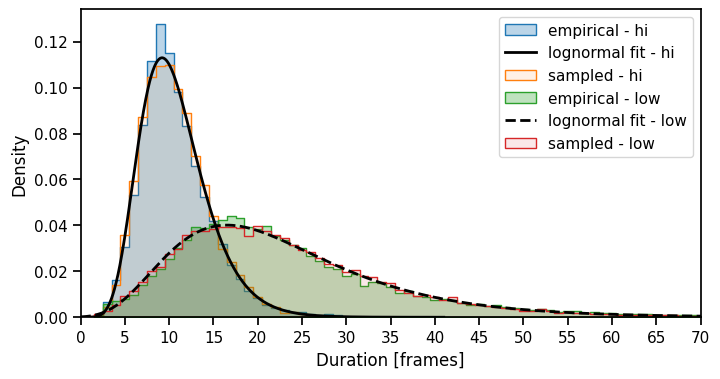

In [15]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt.subplots_adjust(wspace=0.3)

print(f"Selected groups:\n - {groups}")

params_list = []
for idx, var in enumerate(vars):

    # get data and plot histogram
    data = get_univariate_data(PRC_df, groups, var, states=states, thresh=thresh_values[idx], first_response_only=True)
    fig = plot_univariate(data, x_label=var, title=var, x_max=x_max_values[idx], x_step=5, label="empirical - " + labels[idx], ax=ax)

    # fit data to lognormal distribution and plot PDF
    params = stats.lognorm.fit(data)
    xs = np.linspace(0, x_max_values[idx] + 1, 1000)
    pdf = stats.lognorm.pdf(xs, params[0], params[1], params[2])
    ax.plot(xs, pdf, '-' + '-'*idx, lw=2, label="lognormal fit - " + labels[idx], color="black")
    params_list.append(params)

    # draw samples from the best fit distribution and plot histogram
    n_samps = 20000
    samples = stats.lognorm.rvs(params[0], loc=params[1], scale=params[2], size=n_samps)
    sns.histplot(np.round(samples), ax=ax, discrete=True, kde=False, stat="density", element="step", label="sampled - " + labels[idx], alpha=0.1)

    # set plot labels and titles
    ax.set_title("")
    ax.set_xlabel("Duration [frames]")
    ax.set_ylabel("Density")
    ax.set_xlim([0, x_max_values[idx]])
    ax.legend()

    # print best fit lognormal parameters
    print(f"\nBest fit lognormal params for {var}:\n - (s, loc, scale) = {np.round(params, 3)}")

# Show the plots
plt.show()

global_params_hi, global_params_lo = params_list

Individually fit each group in the Light condition

In [16]:
def plot_fit_by_group(PRC_df, groups, var, f_nums=[0,1], states="all", x_max=25, x_step=5, thresh=None, n_rows=4, n_cols=5, figsize=(12,6), first_response_only=False):

    # create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # list of data and params by focal fish number and group
    data_f_g = [[] for _ in range(len(f_nums))]
    params_f_g = [[] for _ in range(len(f_nums))]

    line_styles = ["-","--"]

    # loop through focal fish number
    for f in f_nums:
        plot_idx = 0

        # loop through groups
        for g, group in enumerate(groups):    

            # get group data
            data = get_univariate_data(PRC_df, [group], var, f_num=[f], states=states, thresh=thresh, first_response_only=first_response_only)
            data_f_g[f].append(data)
        
            # Plot data on the current axis
            ax = axes[plot_idx]
            plot_univariate(data, x_label=var, x_max=x_max, ax=ax, x_step=x_step, alpha=0.2, label="data: f_num={}".format(f))
            
            # fit data to lognormal distribution and get parameters
            params = stats.lognorm.fit(data) 
            params_f_g[f].append(params)

            # generate PDF 
            xs = np.linspace(0, x_max+1, 1000)
            pdf = stats.lognorm.pdf(xs, params[0], params[1], params[2])
            ax.plot(xs, pdf, ls=line_styles[f], lw=1, label="fit: f_num={}".format(f), color="black")
            
            # increment subplot index
            plot_idx += 1

            ax.set_xlabel("")
            ax.set_ylabel("")

            # Add text to the top-right corner of each subplot
            fig.text(0.95, 0.95, f"group {group}", transform=ax.transAxes, ha='right', va='top', fontsize=10)

            if plot_idx == n_cols:
                ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), borderaxespad=0.)

    # Add the shared x and y labels outside the grid
    fig.text(0.445, -0.01, 'duration (frames)', ha='center', va='center', fontsize=12)
    fig.text(-0.002, 0.47, 'density', ha='center', va='center', rotation='vertical', fontsize=12)

    if "hi" in var:
        fig.suptitle("active durations of focal fish", fontsize=16, x=0.445, y=0.97)
    elif "low" in var:
        fig.suptitle("inactive durations of focal fish", fontsize=16, x=0.45, y=0.97)

    plt.tight_layout()
    return data_f_g, params_f_g

In [17]:
# select groups to pull data from
c_sel = (PRC_df["class"]==0)
groups = PRC_df[c_sel]["group"].unique()

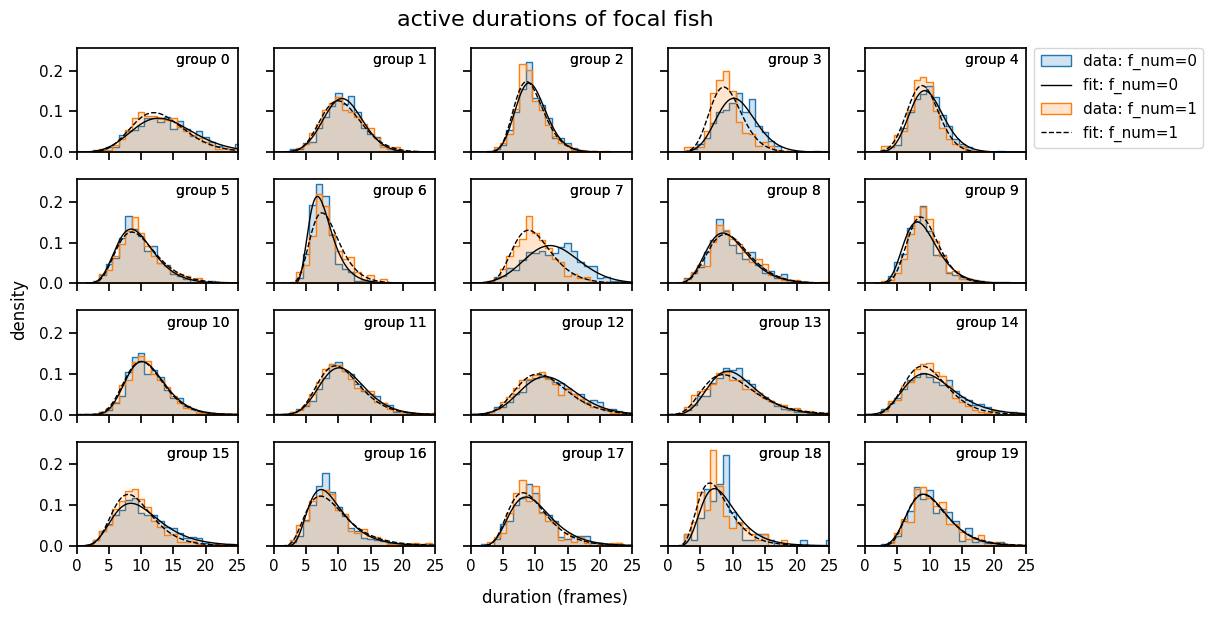

In [18]:
var = "partner_hi_duration" 
x_max = 25
thresh = 30
states = [0,1]
f_nums = [0,1]

data_hi_f_g, params_hi_f_g = plot_fit_by_group(
    PRC_df, groups, var, f_nums=f_nums, states=states, x_max=x_max, thresh=thresh
)

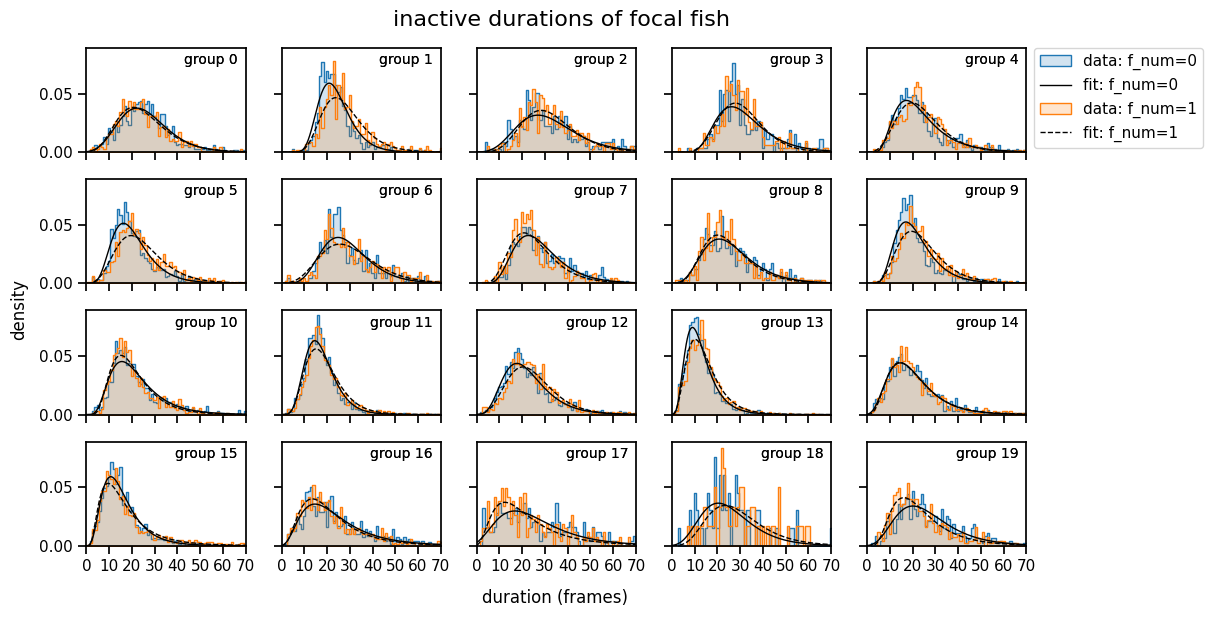

In [19]:
var = "partner_low_duration" 
x_max = 70
thresh = 75
states = [0,1]
f_nums = [0,1]

data_lo_f_g, params_lo_f_g = plot_fit_by_group(
    PRC_df, groups, var, f_nums=f_nums, states=states, x_max=x_max, x_step=10, thresh=thresh
)

# __Step 3__: Generate synthetic coupled pulses
_____

We consider six possible interaction states, with the social interactions based on phase response curves (PRCs). That is, if the partner fish responds to the start of the focal's movement with some response lag $\tau$, then the fish are swimming in-phase if the focal fish's period $T=\tau$. If instead $T=2\tau$, the fish are swimming out-of-phase.

The states are:

0. in-phase (slope = 1)
1. out-of-phase (slope = 2)
2. instantaneous (slope = N/A)
3. independent swimming (slope = N/A)
4. focal swims, partner unresponsive (slope = N/A)
5. focal unresponsive, partner swims (slope = N/A)

For the in- and out-of-phase states, we include response lag noise $\sim \mathcal{N}(0,4)$. For the instantaneous response state, we draw the response lag from the half-normal distribution $Y = |X|$ where the normally distributed random variable $X \sim \mathcal{N}(0,2.5)$. For the independent swimming states, we manually insert independetly generated pulses for the fish in question. Similarily, we independently generate null pulses for unresponsive fish, but include some small probability of moving.

In short, the data generation procedure is as follows:
1. Draw focal fish high and low durations from conditional distribution conditioned on previous $n$ values
2. Draw response lag of fish using the period of the focal fish (or manually insert independent pulses if in non-social states)
3. Draw high duration for partner fish, low duration is not drawn but defined by waiting until the next response to the focals movement
4. Repeat steps

## 3a. Examine joint bivariate distributions of high and low durations to determine correlation coefficients

In [42]:
def get_bivariate_data(df, group, x_var, y_var, f_num=0, first_response_only=True):
    
    f_nums = [0,1] if f_num=="both" else list(f_num)

    # make group and focal fish number selections
    g_f_sel = (df["group"].isin(list(group))) & (df["focal_fish"].isin(f_nums))
    if first_response_only:
        g_f_sel = g_f_sel & (df["first_response"] == True) 
    
    # get data 
    data_x = df[g_f_sel][x_var].to_numpy()
    data_y = df[g_f_sel][y_var].to_numpy()

    return data_x, data_y

    
def plot_bivariate(data_x, data_y, x_label="", y_label="", offset=0, x_max=20, y_max=20,
                   x_step=2, y_step=2, title=None, cmp="afmhot", figsize=(4,4), grid=None, lines=True):
    
    # If no axis is passed, create a new plot
    if grid is None:
        fig = plt.figure(figsize=figsize)
        grid = grid[0]
    
    # get data 
    if offset != 0:
        data_x = data_x[:-offset]
        data_y = data_y[offset:]

    # create grid 
    x_range = np.linspace(0, x_max, x_max + 1) 
    y_range = np.linspace(0, y_max, y_max + 1)
    grid_x, grid_y = np.meshgrid(x_range[:-1], y_range[:-1])

    # compute 2D histogram and plot
    heatmap, xedges, yedges = np.histogram2d(data_x, data_y, bins=(x_range, y_range), density=False)

    vmax = np.percentile(heatmap, 99.9)    
    im = grid.imshow(heatmap.T, origin='lower', aspect='equal', cmap=cmp, vmin=0, vmax=vmax, extent=[0, x_max, 0, y_max])

    if lines:
        if x_max >= y_max:
            grid.plot([0, y_max], [0, y_max], color='white', linestyle=':', linewidth=2, label='y=x')
        else:
            grid.plot([0, x_max], [0, x_max], color='white', linestyle=':', linewidth=2, label='y=x')

    grid.set_xticks(np.arange(x_max+1, step=x_step))
    grid.set_yticks(np.arange(y_max+1, step=y_step))

    # set x and y labels
    grid.set_xlabel(x_label + " (n)")
    grid.set_ylabel(y_label + " (n+L)")
    # grid.text(0.5, -0.1, x_label + " (n)", transform=grid.transAxes, ha="center", size=12)
    
    if title:
        grid.set_title(title)


def draw_plot_bivariate_lognormal(params_x, params_y, rho, n_samps=10000, x_label="", y_label="", x_max=20, y_max=20, 
                                  x_step=2, y_step=2, title=None, cmp="afmhot", figsize=(4,4), grid=None, lines=True):
    # unpack lognormal params
    sigma_x, loc_x, shape_x = params_x
    sigma_y, loc_y, shape_y = params_y

    # get mean vector
    means = np.array([np.log(shape_x), np.log(shape_y)])

    # get covariance matrix
    cov_mat = np.array([
        [sigma_x**2, rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2],
    ])

    # draw samples from bivariate normal distribution
    x_samps, y_samps = np.random.multivariate_normal(means, cov_mat, size=n_samps).T

    # transform samples to lognormal and round
    x_samps = np.round(np.exp(x_samps) + loc_x)
    y_samps = np.round(np.exp(y_samps) + loc_y)
    
    # create grid 
    x_range = np.linspace(0, x_max, x_max + 1) 
    y_range = np.linspace(0, y_max, y_max + 1)
    grid_x, grid_y = np.meshgrid(x_range[:-1], y_range[:-1])

    # compute 2D histogram and plot
    heatmap, xedges, yedges = np.histogram2d(x_samps, y_samps, bins=(x_range, y_range), density=False)
    vmax = np.percentile(heatmap, 99.9)    
    
    if grid is None:
        fig = plt.figure(figsize=figsize)
        grid = grid[0]

    im = grid.imshow(heatmap.T, origin='lower', aspect='equal', cmap=cmp, vmin=0, vmax=vmax, extent=[0, x_max, 0, y_max])

    if lines:
        if x_max >= y_max:
            grid.plot([0, y_max], [0, y_max], color='white', linestyle=':', linewidth=2, label='y=x')
        else:
            grid.plot([0, x_max], [0, x_max], color='white', linestyle=':', linewidth=2, label='y=x')

    grid.set_xticks(np.arange(x_max+1, step=x_step))
    grid.set_yticks(np.arange(y_max+1, step=y_step))
    x_mid = (grid.get_xlim()[0] + grid.get_xlim()[1]) / 2
    y_loc = (grid.get_ylim()[0] + grid.get_ylim()[1]) / 2

    grid.set_xlabel(x_label)
    grid.set_ylabel(y_label)

    if title:
        grid.set_title(title)
    return x_samps, y_samps


def optionally_compare_plots(xvar, yvar, lags, rhos=None, figsize=(9,5), lines=True):

    # axes limits and ticks and params
    if "low" in xvar: xmax = 60; xstep = 10; lognorm_params_x = global_params_lo
    else:             xmax = 20; xstep = 5;  lognorm_params_x = global_params_hi
    if "low" in yvar: ymax = 60; ystep = 10; lognorm_params_y = global_params_lo
    else:             ymax = 20; ystep = 5;  lognorm_params_y = global_params_hi

    # make plot for empirical data
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, len(lags)), axes_pad=0.4, cbar_mode=None)
    grid[0].text(-0.7, 0.5, "Empirical:", transform=grid[0].transAxes, va="center", ha="center", size=16)

    for i, lag in enumerate(lags):
        data_x, data_y = get_bivariate_data(PRC_df, groups, xvar, yvar, f_num, first_response_only=True)
        plot_bivariate(data_x, data_y, xvar, yvar, offset=lag, x_max=xmax, y_max=ymax, 
                    x_step=xstep, y_step=ystep, grid=grid[i], title=f"L = {lag}", lines=lines)

    if rhos:
        # make plot for estimated bivariate distns (we choose rho but use the log-norm univariate distn fit from the data) 
        fig = plt.figure(figsize=figsize)
        grid = ImageGrid(fig, 111, nrows_ncols=(1,len(rhos)), axes_pad=0.4, cbar_mode=None)
        grid[0].text(-0.7, 0.5, "Generated:", transform=grid[0].transAxes, va="center", ha="center", size=16)

        for i, rho in enumerate(rhos):
            draw_plot_bivariate_lognormal(lognorm_params_x, lognorm_params_y, rhos[i], n_samps=32000, x_label=xvar, y_label=yvar, 
                                        x_max=xmax, y_max=ymax, x_step=xstep, y_step=ystep, grid=grid[i], title=f"Rho = {rhos[i]}", lines=lines)

In [43]:
# select groups to get data from
groups = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19]

# select focal fish number(s) (just do both if you want to see data for all fish)
f_num = [0,1]  

First, lets look at the low durations. We plot the empirical data and then use the univariate distribution best fit params to plot the joint bivariate distribution (we just have to guess the correlation coeff $\rho$). This gives us an estimate of the correlation coefficients $\rho_L$ where $L$ is the number of lagged bouts. As expected, $\rho_L$ decreases as $L$ increases 

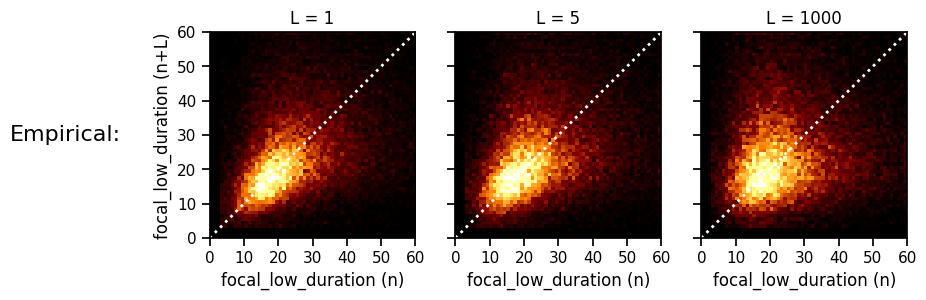

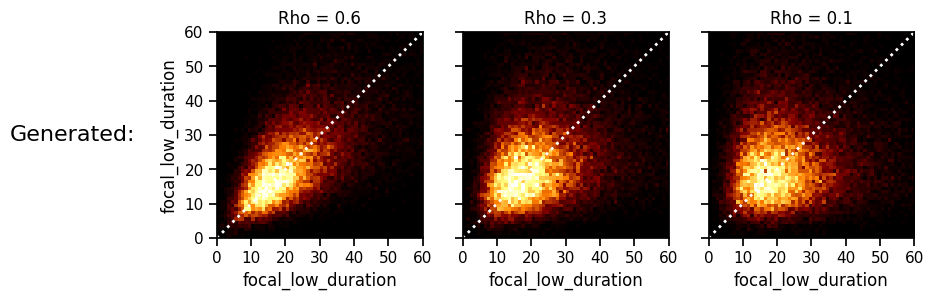

In [44]:
# select variables
xvar = "focal_low_duration"
yvar = "focal_low_duration"

# choose num of plots to display
lags = [1, 5, 1000]     # num bouts between the x and y variables 
rhos = [0.6, 0.3, 0.1]  # guestimate corr coeffs that match what we see in empirical heatmaps

optionally_compare_plots(xvar, yvar, lags, rhos)

Next we plot the distributions for high durations. It's more difficult to guess what the correct $\rho_L$ is since the distributions are highly pixelated. But it does give a demonstration that there is some correlation between bout durations at different lags.

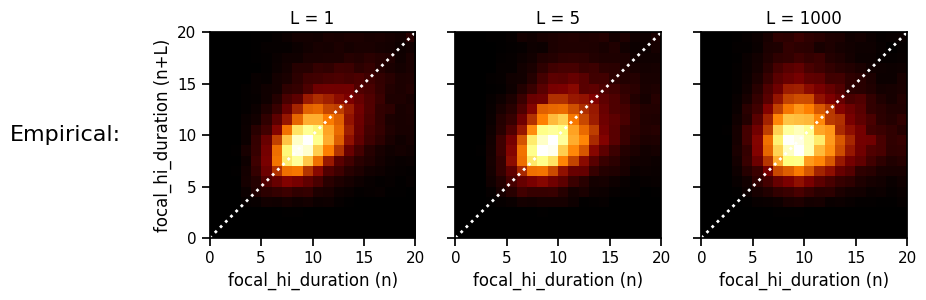

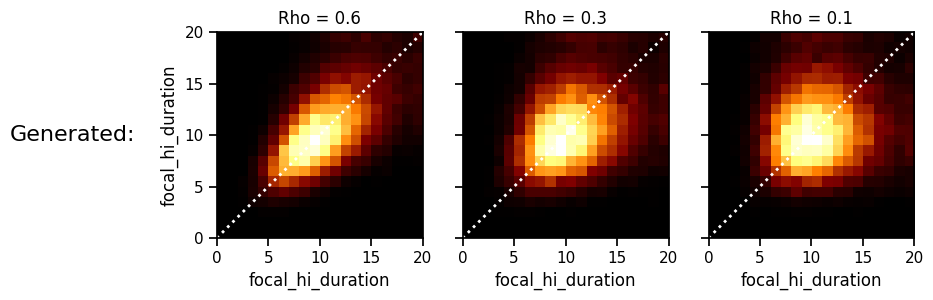

In [45]:
# select variables
xvar = "focal_hi_duration"
yvar = "focal_hi_duration"

# choose num of plots to display
lags = [1, 5, 1000]     # num bouts between the x and y variables 
rhos = [0.6, 0.3, 0.1]  # guestimate corr coeffs that match what we see in empirical heatmaps

optionally_compare_plots(xvar, yvar, lags, rhos)

Finally, we show that the high and low durations aren't meaningfully correlated. This means that we can generate the high and low pulse durations independently.

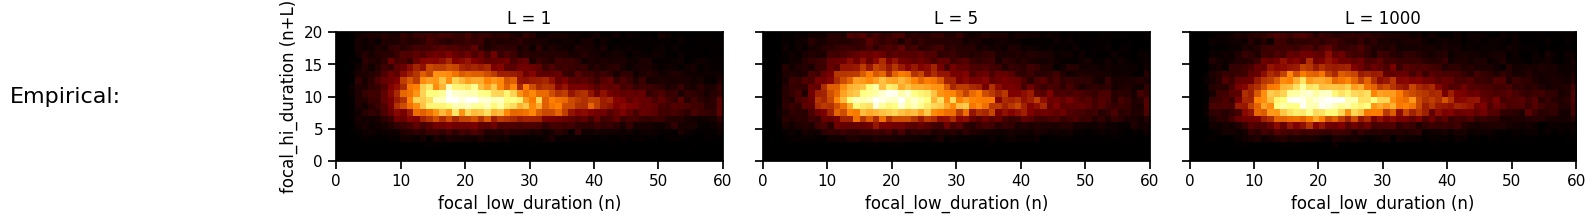

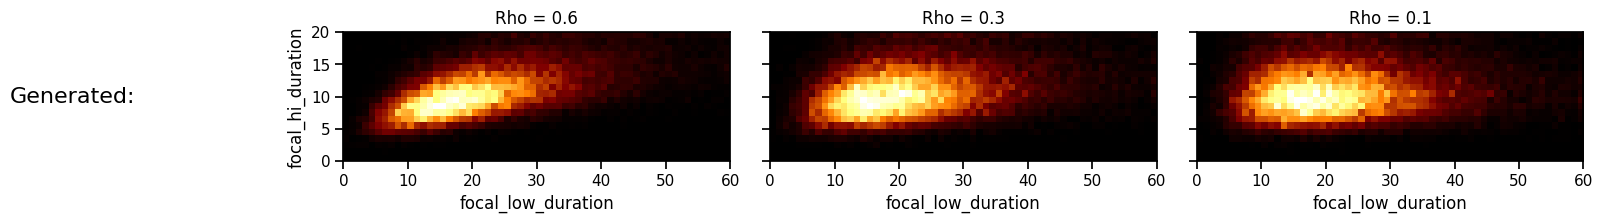

In [46]:
# select variables
xvar = "focal_low_duration"
yvar = "focal_hi_duration"

# choose num of plots to display
lags = [1, 5, 1000]     # num bouts between the x and y variables 
rhos = [0.6, 0.3, 0.1]  # guestimate corr coeffs that match what we see in empirical heatmaps

optionally_compare_plots(xvar, yvar, lags, rhos, figsize=(16,6), lines=False)

Of course, the hi & low durations between focal and partner fish are correlated, but we will build this into the generated pulses by setting the response time of the partner fish to depend on the period of the focal fish.

Now we choose the number of previous bouts to condition on and their correlation coefficients $\rho_{1,L}$. We use a decaying exponential that roughly mimics what we observe in the empirical data. 

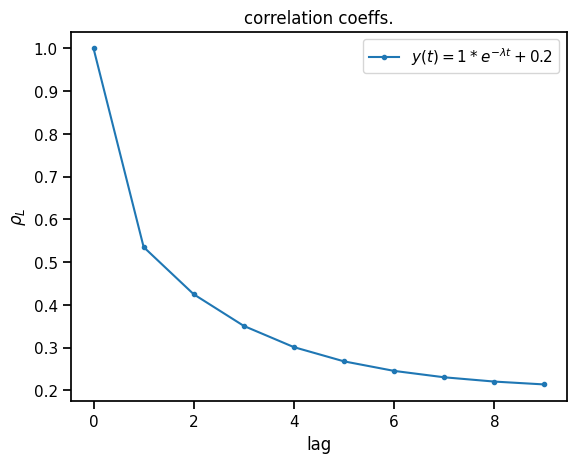

In [47]:
# choose num of previous bouts to condition on - 1
t_max = 10

# define decaying exponential params
A = 0.5
B = 0.2
l = 0.4

# compute decaying exponential
t = np.arange(1, t_max)
y = A * np.exp(-l * t) + B

# append rho = 1 for 0 lag
t = [0] + list(t)
rhos = [1] + list(y)

plt.plot(t, rhos, '.-', label=r'$y(t) = 1 * e^{-\lambda t} + 0.2$')
plt.xlabel("lag")
plt.ylabel(r"$\rho_L$")
plt.title("correlation coeffs.")
plt.legend()
plt.show()

For convenience, we use the same rhos for the high and low durations.

In [48]:
hi_rhos = rhos
lo_rhos = rhos

## 3b. Use best-fit empirical distribution parameters to generate synthetic pulses

In [32]:
def get_cond_sig(cov_mat):
    """
    Gets conditional distn p(x|y,z,...) assuming
    were conditioning on element 00 of cov_mat
    """
    # break mat into components
    var_00 = cov_mat[0,0]
    vec = cov_mat[1:,0:1]
    B = cov_mat[1:,1:]
    sigma_cond = np.sqrt(var_00 - vec.T @ linalg.inv(B) @ vec)
    return sigma_cond[0,0]


def get_cond_mean(cond_vars, means, cov_mat, loc):
    """
    Gets conditional mean of p(x|y,z,...)
    """
    # transform conditioning variables
    cond_vars = np.log(cond_vars - loc)

    # split mus
    mu_0 = means[0]
    mus = np.reshape(means[1:],(-1,1))
    # break mat into components
    vec = cov_mat[1:,0:1]
    B = cov_mat[1:,1:]

    mu_cond = mu_0 + vec.T @ linalg.inv(B) @ (cond_vars - mus)
    return mu_cond[0,0]


def get_cond_lognormal_params(cond_vars, means, cov_mat, loc):
    """
    means (np.array): Mean vector of multivariate gaussian
    cov_mat (np.array): Covariance matrix of multivariate Gaussian
    loc: Shift on log normal distribution
    """
    # get conditional normal parms
    cond_mu = get_cond_mean(cond_vars, means, cov_mat, loc)
    cond_sig = get_cond_sig(cov_mat)

    # get lognormal params
    cond_lognorm_params = (cond_sig, loc, np.exp(cond_mu))
    return cond_lognorm_params


def draw_cond_lognorm(cond_vars, means, cov_mat, loc, bounds=(0,100), min=0):
    if isinstance(cond_vars, list):
        cond_vars = np.array(cond_vars)
        
    if cond_vars.ndim == 1:
        cond_vars = np.reshape(cond_vars, (-1, 1))
    
    # Get conditional lognormal parameters (this function is assumed to be implemented)
    params = get_cond_lognormal_params(cond_vars, means, cov_mat, loc)
    
    # Define the bounds based on the given percentiles
    lower_bound = stats.lognorm.ppf(bounds[0] / 100, *params)
    upper_bound = stats.lognorm.ppf(bounds[1] / 100, *params)

    samp = -1
    while (samp < min) or not (lower_bound < samp < upper_bound):
        samp = stats.lognorm.rvs(params[0], loc=params[1], scale=params[2])
    
    return samp, params

Define states and define probability of being in each state.

In [34]:
# set states
n_states = 6
states = np.arange(n_states)

# define state names
state_names = [
    "in-phase",
    "out-of-phase",
    "instantaneous",
    "both independent",
    "unresponsive partner",
    "unresponsive focal"
]

# set slopes for each state
slope_by_state = [1, 0.5, None, None, None, None]

# set state frequencies
state_probs = [1 / n_states] * n_states

Get state durations that are similar to those observed in the empirical data.

In [37]:
def draw_state_seq(n_bouts, slope_by_state, state_prob, params=(0.7,0.9,5)):
    
    assert len(slope_by_state) == len(state_prob)
    states = np.arange(len(state_prob))
    state_seq = []
    slopes = []

    i = 0
    while i < n_bouts:

        # draw state duration from lognormal distribution
        state_dur = np.inf
        while state_dur > 100:
            state_dur = int(stats.lognorm.rvs(params[0], loc=params[1], scale=params[2]))

        # draw state number and append sequence
        state = np.random.choice(states, p=state_prob)
        for _ in range(state_dur):
            state_seq.append(state)
            slopes.append(slope_by_state[state])

        i += state_dur

    return state_seq[:n_bouts], slopes[:n_bouts]

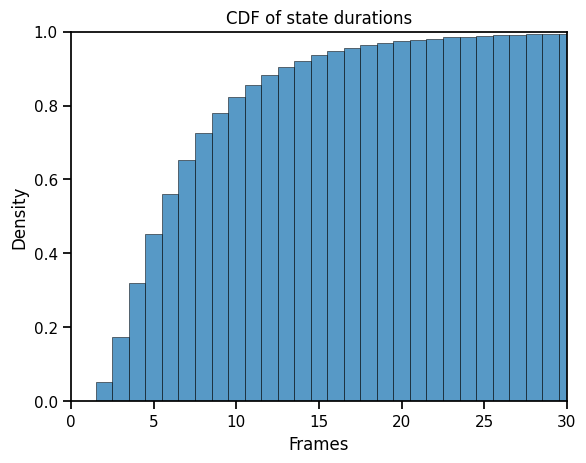

In [38]:
p=(0.7,0.9,5)
a = np.round(stats.lognorm.rvs(p[0], loc=p[1], scale=p[2], size=100000))
sns.histplot(a, binwidth=1, cumulative=True, stat="density", discrete=True)
plt.xlim(0,30)
plt.ylim(0,1)
plt.title("CDF of state durations")
plt.xlabel("Frames")
plt.show()

Generate coupled pulses

In [49]:
def process_groups(sel_groups, n_bouts, 
    f_hi_params_list, f_lo_params_list, p_hi_params_list, p_lo_params_list, hi_rhos, lo_rhos, 
    f0_hi_cond_vars, f0_lo_cond_vars, f1_hi_cond_vars, f1_lo_cond_vars, 
    hi_bounds=(6, 95), social_lo_bounds=(8, 88), null_lo_bounds=(5, 97),
    state_probs=state_probs, slope_by_state=slope_by_state, focal_change_rate=100, PRC_spread=4):

    assert len(f0_lo_cond_vars) == len(f0_hi_cond_vars) == \
           len(f1_lo_cond_vars) == len(f1_hi_cond_vars) == len(hi_rhos)-1

    # init lists
    fish0_hi_durs_by_group = []
    fish0_lo_durs_by_group = []
    fish0_periods_by_group = []

    fish1_hi_durs_by_group = []
    fish1_lo_durs_by_group = []
    fish1_periods_by_group = []

    resp_lags_by_group = []
    state_seq_by_group = []
    focal_fish_num_seq_by_group = []

    # generate for each synthetic group
    for g in range(len(sel_groups)):

        # Get means for the group
        fish0_hi_means = np.log(f_hi_params_list[g][2]) * np.ones(len(hi_rhos))
        fish0_lo_means = np.log(f_lo_params_list[g][2]) * np.ones(len(lo_rhos))
        fish1_hi_means = np.log(p_hi_params_list[g][2]) * np.ones(len(hi_rhos))
        fish1_lo_means = np.log(p_lo_params_list[g][2]) * np.ones(len(lo_rhos))

        # Get covariance matrices for the group
        fish0_hi_cov = f_hi_params_list[g][0]**2 * linalg.toeplitz(hi_rhos)
        fish0_lo_cov = f_lo_params_list[g][0]**2 * linalg.toeplitz(lo_rhos)
        fish1_hi_cov = p_hi_params_list[g][0]**2 * linalg.toeplitz(hi_rhos)
        fish1_lo_cov = p_lo_params_list[g][0]**2 * linalg.toeplitz(lo_rhos)

        # Initialize lists to store the results
        fish0_hi_durs = []
        fish0_lo_durs = []
        fish0_periods = []
        fish1_hi_durs = []
        fish1_lo_durs = []
        fish1_periods = []
        resp_lags = []
        f_num_seq = []
        focal_fish_num = 0

        # Draw state sequence for the group
        state_seq, slopes = draw_state_seq(n_bouts, slope_by_state, state_probs)

        # Loop through bouts to generate the data for this group
        for i in range(n_bouts):

            # Get state & slope for PRC relationship
            state = state_seq[i]
            slope = slopes[i]

            # get low bounds (depends on state)
            lo_bounds = null_lo_bounds if state > 2 else social_lo_bounds

            # Draw durations based on the state
            fish0_hi_samp, _ = draw_cond_lognorm(f0_hi_cond_vars, fish0_hi_means, fish0_hi_cov, f_hi_params_list[g][1], bounds=hi_bounds)
            fish0_lo_samp, _ = draw_cond_lognorm(f0_lo_cond_vars, fish0_lo_means, fish0_lo_cov, f_lo_params_list[g][1], bounds=lo_bounds)
            fish1_hi_samp, _ = draw_cond_lognorm(f1_hi_cond_vars, fish1_hi_means, fish1_hi_cov, p_hi_params_list[g][1], bounds=hi_bounds)
            fish1_lo_samp, _ = draw_cond_lognorm(f1_lo_cond_vars, fish1_lo_means, fish1_lo_cov, p_lo_params_list[g][1], bounds=lo_bounds)

            # Update conditioning variables
            f0_hi_cond_vars = [np.round(fish0_hi_samp)] + f0_hi_cond_vars[:-1]
            f0_lo_cond_vars = [np.round(fish0_lo_samp)] + f0_lo_cond_vars[:-1]
            f1_hi_cond_vars = [np.round(fish1_hi_samp)] + f1_hi_cond_vars[:-1]
            f1_lo_cond_vars = [np.round(fish1_lo_samp)] + f1_lo_cond_vars[:-1]

            # Calculate periods for both fish
            fish0_period = fish0_hi_samp + fish0_lo_samp
            fish1_period = fish1_hi_samp + fish1_lo_samp
            periods = [fish0_period, fish1_period]
            f_period = periods[focal_fish_num]

            # swap fish periodically and get focal period
            if (i % focal_change_rate == 0) & (i > 0):
                focal_fish_num = -1 * focal_fish_num + 1
            f_num_seq.append(focal_fish_num)
            f_period = periods[focal_fish_num]

            # draw response lags based on state
            if state < 2:  # In-phase or out-of-phase
                p_response_lag = np.round(slope * f_period).astype(int) + np.round(np.random.normal(scale=PRC_spread)).astype(int)
            elif state == 2:  # Instant response state
                p_response_lag = np.abs(np.random.normal(0, 2.5))
            # for non-interacting states, lag doesnt matter since we
            # will manually insert pulses for these sequences later
            else:  
                p_response_lag = np.random.choice(np.arange(f_period))

            # Append data to lists
            fish0_hi_durs.append(fish0_hi_samp)
            fish0_lo_durs.append(fish0_lo_samp)
            fish0_periods.append(fish0_period)
            fish1_hi_durs.append(fish1_hi_samp)
            fish1_lo_durs.append(fish1_lo_samp)
            fish1_periods.append(fish1_period)
            resp_lags.append(p_response_lag)

        # append to group lists
        fish0_hi_durs_by_group.append(fish0_hi_durs)
        fish0_lo_durs_by_group.append(fish0_lo_durs)
        fish0_periods_by_group.append(fish0_periods)
        fish1_hi_durs_by_group.append(fish1_hi_durs)
        fish1_lo_durs_by_group.append(fish1_lo_durs)
        fish1_periods_by_group.append(fish1_periods)
        resp_lags_by_group.append(resp_lags)
        state_seq_by_group.append(state_seq)
        focal_fish_num_seq_by_group.append(f_num_seq)

    return (
        fish0_hi_durs_by_group, 
        fish0_lo_durs_by_group, 
        fish0_periods_by_group, 
        fish1_hi_durs_by_group, 
        fish1_lo_durs_by_group, 
        fish1_periods_by_group, 
        resp_lags_by_group, 
        state_seq_by_group, 
        focal_fish_num_seq_by_group
    )

In [51]:
# choose groups
sel_groups = [0,4,5,6,7,8,9,10,11,12,13,14,15,16,19]

# choose num bouts to generate
n_bouts = 6000

# define conditioning vars
f0_hi_cond_vars = [8  for _ in range(len(hi_rhos)-1)] 
f0_lo_cond_vars = [16 for _ in range(len(lo_rhos)-1)]
f1_hi_cond_vars = [8  for _ in range(len(hi_rhos)-1)] 
f1_lo_cond_vars = [16 for _ in range(len(lo_rhos)-1)]

# set hi bounds
hi_bounds = (3, 95)

# set low bounds
social_lo_bounds = (1, 88)
null_lo_bounds = (3, 98)

In [52]:
(
    fish0_hi_durs_by_group, 
    fish0_lo_durs_by_group, 
    fish0_periods_by_group, 
    fish1_hi_durs_by_group, 
    fish1_lo_durs_by_group, 
    fish1_periods_by_group, 
    resp_lags_by_group, 
    state_seq_by_group, 
    focal_fish_num_seq_by_group
) = process_groups(sel_groups, n_bouts, 
        params_hi_f_g[0], params_lo_f_g[0], params_hi_f_g[1], params_lo_f_g[1], hi_rhos, lo_rhos, 
        f0_hi_cond_vars, f0_lo_cond_vars, f1_hi_cond_vars, f1_lo_cond_vars, hi_bounds, social_lo_bounds, null_lo_bounds,
        state_probs, slope_by_state, focal_change_rate=100, PRC_spread=4
    )

Compare global distributions of synthetic and empirical data

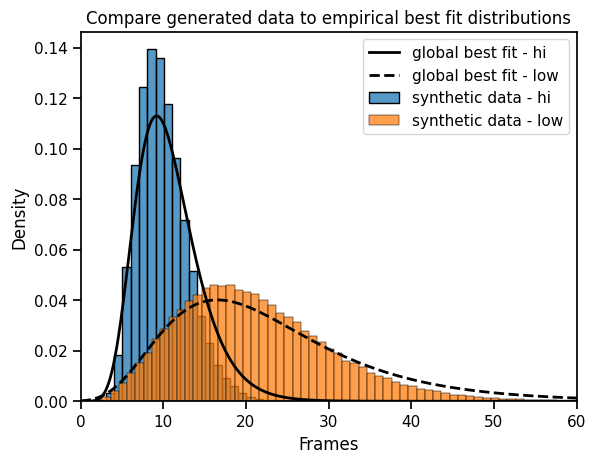

In [58]:
# concatenate all samples and plot
synth_hi_durs = np.concatenate(fish0_hi_durs_by_group + fish1_hi_durs_by_group)
synth_lo_durs = np.concatenate(fish0_lo_durs_by_group + fish1_lo_durs_by_group)
sns.histplot(synth_hi_durs, stat="density", discrete=True, label="synthetic data - hi")
sns.histplot(synth_lo_durs, stat="density", discrete=True, label="synthetic data - low")

# compare synth data to empirical global PDF
xs = np.linspace(0, 100 + 1, 1000)
pdf = stats.lognorm.pdf(xs, global_params_hi[0], global_params_hi[1], global_params_hi[2])
plt.plot(xs, pdf,'-', lw=2, color="black", label="global best fit - hi")
pdf = stats.lognorm.pdf(xs, global_params_lo[0], global_params_lo[1], global_params_lo[2])
plt.plot(xs, pdf,'--', lw=2, color="black", label="global best fit - low")
plt.xlim(0,60)
plt.xlabel("Frames")
plt.title("Compare generated data to empirical best fit distributions")
plt.legend()
plt.show()

We have successfully generated data that looks similar to what we observe in the real fish!

## 3c. Reconstruct pulses

In [31]:
def reconstruct_pulses(sel_groups, n_bouts, state_seq_by_group, focal_fish_num_seq_by_group, 
                       fish0_hi_durs_by_group, fish1_hi_durs_by_group, 
                       fish0_lo_durs_by_group, fish1_lo_durs_by_group, 
                       resp_lags_by_group, verbose=True):

    # store pulses
    fish0_pulses_by_group = []
    fish1_pulses_by_group = []
    state_pulses_by_group = []
    focal_fish_pulses_by_group = []

    # store concat pulses
    fish0_pulses_concat_by_group = []
    fish1_pulses_concat_by_group = []
    state_pulses_concat_by_group = []
    focal_fish_pulses_concat_by_group = []

    # loop through selected groups
    for g, group in enumerate(sel_groups):

        # initialize lists to store the pulses
        fish0_pulses = []
        fish1_pulses = []
        state_pulses = []
        focal_fish_pulses = []

        # initialize the overflow flag and storage for remaining pulses
        overflow = 0
        overflow_partner_pulse = []

        # initialize flag for overflow case 2 and record states where this happens
        o2 = 0
        o2_states = []

        # probability of focal fish not moving by state
        prob_f_null_by_state = [0.00, 0.00, 0.00, 0.00, 0.00, 0.00]

        # iterate over focal fish bout lengths and interbout intervals
        for i in range(n_bouts - 2):

            # get state and focal fish number
            state = state_seq_by_group[g][i]
            f_num = focal_fish_num_seq_by_group[g][i]
            p_num = -1 * f_num + 1

            # check if focal fish num will change next bout
            f_num_change = np.abs(focal_fish_num_seq_by_group[g][i + 1] - focal_fish_num_seq_by_group[g][i])

            # get hi and lo durations for each fish
            hi_dur = [fish0_hi_durs_by_group[g][i], fish1_hi_durs_by_group[g][i]]
            f_hi_dur = hi_dur[f_num]
            p_hi_dur = hi_dur[p_num]
            lo_dur = [fish0_lo_durs_by_group[g][i], fish1_lo_durs_by_group[g][i]]
            f_lo_dur = lo_dur[f_num]
            p_lo_dur = lo_dur[p_num]

            # construct focal fish pulse
            focal_pulse = [1] * int(f_hi_dur) + [0] * int(f_lo_dur)

            # get partner fish pulse properties
            p_lag = resp_lags_by_group[g][i]
            if overflow == 0:
                # no overflow; generate a new partner pulse
                partner_pulse = [0] * int(p_lag) + [1] * int(p_hi_dur)
            else:
                # handle overflow from the previous bout
                overflow_len = len(overflow_partner_pulse)

                # case 1: overflow fits within the current focal pulse
                if overflow == 1:
                    dif = p_lag - overflow_len
                    partner_pulse = overflow_partner_pulse + [0] * int(dif) + [1] * int(p_hi_dur)

                # case 2: overflow doesn't fit within current focal pulse
                elif overflow == 2:
                    dif = len(focal_pulse) - overflow_len
                    partner_pulse = overflow_partner_pulse[:len(focal_pulse)]  # truncate overflow to fit current bout (this should not happen often)
                    o2 += 1
                    o2_states.append(state)

            # adjust for pulse length differences
            pulse_len_dif = len(partner_pulse) - len(focal_pulse)

            # overflow scenario: partner pulse is longer than focal pulse
            if pulse_len_dif > 0:
                overflow_partner_pulse = partner_pulse[len(focal_pulse):]  # save overflow for the next iteration
                partner_pulse = partner_pulse[:len(focal_pulse)]
                next_p_lag = resp_lags_by_group[g][i + 1]

                # decide the overflow state based on the next partner lag
                if len(overflow_partner_pulse) < next_p_lag:
                    overflow = 1  # overflow can fit within the next lag
                else:
                    overflow = 2  # overflow will still exceed the next lag

            # no overflow; pad the partner pulse if needed
            else:
                partner_pulse.extend([0] * (len(focal_pulse) - len(partner_pulse)))
                overflow_partner_pulse = []
                overflow = 0

            # reset overflow
            if (pulse_len_dif <= 0) | f_num_change:
                overflow_partner_pulse = []
                overflow = 0

            # append the partner pulse to the list
            if f_num == 0:
                fish0_pulses.append(focal_pulse)
                fish1_pulses.append(partner_pulse)
            else:
                fish0_pulses.append(partner_pulse)
                fish1_pulses.append(focal_pulse)

            # get state pulses and focal fish nums
            state_pulse = [state_seq_by_group[g][i]] * int(len(partner_pulse))
            state_pulses.append(state_pulse)
            focal_fish_pulse = [f_num] * int(len(partner_pulse))
            focal_fish_pulses.append(focal_fish_pulse)

        if verbose:
            print("Group {} instances of overflow 2: {}/{}".format(group, o2, len(fish0_pulses)))

        # append to lists
        fish0_pulses_by_group.append(fish0_pulses)
        fish1_pulses_by_group.append(fish1_pulses)
        state_pulses_by_group.append(state_pulses)
        focal_fish_pulses_by_group.append(focal_fish_pulses)

        # append concatenated pulses
        fish0_pulses_concat_by_group.append(np.concatenate(fish0_pulses))
        fish1_pulses_concat_by_group.append(np.concatenate(fish1_pulses))
        state_pulses_concat_by_group.append(np.concatenate(state_pulses))
        focal_fish_pulses_concat_by_group.append(np.concatenate(focal_fish_pulses))

    return (
        fish0_pulses_by_group, fish1_pulses_by_group, state_pulses_by_group, 
        focal_fish_pulses_by_group, fish0_pulses_concat_by_group, fish1_pulses_concat_by_group, 
        state_pulses_concat_by_group, focal_fish_pulses_concat_by_group
    )

In [32]:
# reconstruct pulses

(
    fish0_pulses_by_group, 
    fish1_pulses_by_group, 
    state_pulses_by_group, 
    focal_fish_pulses_by_group, 
    fish0_pulses_concat_by_group, 
    fish1_pulses_concat_by_group, 
    state_pulses_concat_by_group, 
    focal_fish_pulses_concat_by_group
) = reconstruct_pulses(
        sel_groups, n_bouts, state_seq_by_group, focal_fish_num_seq_by_group, 
        fish0_hi_durs_by_group, fish1_hi_durs_by_group, 
        fish0_lo_durs_by_group, fish1_lo_durs_by_group, 
        resp_lags_by_group, verbose=True
    )

Group 0 instances of overflow 2: 407/5998
Group 4 instances of overflow 2: 264/5998
Group 5 instances of overflow 2: 170/5998
Group 6 instances of overflow 2: 192/5998
Group 7 instances of overflow 2: 307/5998
Group 8 instances of overflow 2: 314/5998


Group 9 instances of overflow 2: 176/5998
Group 10 instances of overflow 2: 310/5998
Group 11 instances of overflow 2: 290/5998
Group 12 instances of overflow 2: 299/5998
Group 13 instances of overflow 2: 430/5998
Group 14 instances of overflow 2: 479/5998
Group 15 instances of overflow 2: 410/5998
Group 16 instances of overflow 2: 726/5998
Group 19 instances of overflow 2: 490/5998


## 3d. Generate pulses for antisocial (independent & non-responsive) states

We first generate pulses of fish swimming independently and fish being non-responsive.

In [33]:
def gen_pulses(n_bouts, hi_cond_vars, lo_cond_vars, hi_params, lo_params, hi_rhos, lo_rhos, 
               hi_bounds=(0,100), lo_bounds=(0,100), chance_of_moving=1):

    # get means
    hi_means = np.log(hi_params[2]) * np.ones(len(hi_rhos))
    lo_means = np.log(lo_params[2]) * np.ones(len(lo_rhos))

    # get covariance matrices
    hi_cov = hi_params[0]**2 * linalg.toeplitz(hi_rhos)
    lo_cov = lo_params[0]**2 * linalg.toeplitz(lo_rhos)

    # init lists
    hi_durs = []
    lo_durs = []
    pulses = []

    for _ in range(n_bouts):

        # draw durations
        hi_samp, _ = draw_cond_lognorm(hi_cond_vars, hi_means, hi_cov, hi_params[1], bounds=hi_bounds)
        lo_samp, _ = draw_cond_lognorm(lo_cond_vars, lo_means, lo_cov, lo_params[1], bounds=null_lo_bounds)

        # update conditioning variables
        hi_cond_vars = [np.round(hi_samp)] + hi_cond_vars[:-1]
        lo_cond_vars = [np.round(lo_samp)] + lo_cond_vars[:-1]

        # append to lists
        hi_durs.append(hi_samp)
        lo_durs.append(lo_samp)

        # construct pulses with chance to be unresponsive
        go_hi = np.random.choice(2, p=(1 - chance_of_moving, chance_of_moving))
        pulses.append([go_hi] * int(hi_samp) + [0] * int(lo_samp))

    return hi_durs, lo_durs, pulses

In [34]:
def gen_pulses_by_group(sel_groups, n_bouts, hi_rhos, lo_rhos, hi_bounds, null_lo_bounds, 
                        f_hi_params_list, f_lo_params_list, p_hi_params_list, p_lo_params_list, 
                        f0_hi_cond_vars, f0_lo_cond_vars, f1_hi_cond_vars, f1_lo_cond_vars, 
                        p_move=1):
    """Generate pulses for each group with some probability `p_move` of moving"""
    # Initialize storage for pulses and durations
    fish0_pulses_by_group = []
    fish0_hi_durs_by_group = []
    fish0_lo_durs_by_group = []
    fish1_pulses_by_group = []
    fish1_hi_durs_by_group = []
    fish1_lo_durs_by_group = []

    # loop through selected groups
    for g, group in enumerate(sel_groups):

        # Generate solo or null pulses for fish 0
        g_hi_durs, g_lo_durs, g_pulses = gen_pulses(
            n_bouts, f0_hi_cond_vars, f0_lo_cond_vars, f_hi_params_list[g], f_lo_params_list[g], 
            hi_rhos, lo_rhos, hi_bounds=hi_bounds, lo_bounds=null_lo_bounds, chance_of_moving=p_move
        )
        fish0_pulses_by_group.append(g_pulses)
        fish0_hi_durs_by_group.append(g_hi_durs)
        fish0_lo_durs_by_group.append(g_lo_durs)

        # Generate solo or null pulses for fish 1
        g_hi_durs, g_lo_durs, g_pulses = gen_pulses(
            n_bouts, f1_hi_cond_vars, f1_lo_cond_vars, p_hi_params_list[g], p_lo_params_list[g], 
            hi_rhos, lo_rhos, hi_bounds=hi_bounds, lo_bounds=null_lo_bounds, chance_of_moving=p_move
        )
        fish1_pulses_by_group.append(g_pulses)
        fish1_hi_durs_by_group.append(g_hi_durs)
        fish1_lo_durs_by_group.append(g_lo_durs)

    return (
        fish0_pulses_by_group, fish0_hi_durs_by_group, fish0_lo_durs_by_group, 
        fish1_pulses_by_group, fish1_hi_durs_by_group, fish1_lo_durs_by_group
    )

In [35]:
# generate independent swimming pulses
p_move = 1

# get generated pulses for each group
(
    fish0_solo_pulses_by_group, fish0_solo_hi_durs_by_group, fish0_solo_lo_durs_by_group, 
    fish1_solo_pulses_by_group, fish1_solo_hi_durs_by_group, fish1_solo_lo_durs_by_group
) = gen_pulses_by_group(
        sel_groups, n_bouts, hi_rhos, lo_rhos, hi_bounds, null_lo_bounds, 
        f_hi_params_list, f_lo_params_list, p_hi_params_list, p_lo_params_list, 
        f0_hi_cond_vars, f0_lo_cond_vars, f1_hi_cond_vars, f1_lo_cond_vars, p_move=p_move
    )

In [36]:
# generate non-responsive swimming pulses (w/ small chance of moving)
p_move = 0.05

# get generated pulses for each group
(
    fish0_null_pulses_by_group, fish0_null_hi_durs_by_group, fish0_null_lo_durs_by_group, 
    fish1_null_pulses_by_group, fish1_null_hi_durs_by_group, fish1_null_lo_durs_by_group
) = gen_pulses_by_group(
        sel_groups, n_bouts, hi_rhos, lo_rhos, hi_bounds, null_lo_bounds, 
        f_hi_params_list, f_lo_params_list, p_hi_params_list, p_lo_params_list, 
        f0_hi_cond_vars, f0_lo_cond_vars, f1_hi_cond_vars, f1_lo_cond_vars, p_move=p_move
    )

Next,  we manually insert these pulses back into the corresponding state sequences of the reconstructed pulses.

In [37]:
def find_sequences(states, focal_nums, k, focal_fish_num):
    """
    Finds and returns the start and end indices of contiguous subsequences where the 
    state is equal to `k` and the focal fish number is equal to `focal_fish_num`.
    """
    sequences = []
    start_index = None
    
    for i, (state, focal_num) in enumerate(zip(states, focal_nums)):
        if (state == k) & (focal_num == focal_fish_num):
            if start_index is None:
                start_index = i
        else:
            if start_index is not None:
                sequences.append((start_index, i - 1))
                start_index = None
    
    if start_index is not None:
        sequences.append((start_index, len(states) - 1))
    
    return sequences


def insert_pulses(sel_groups, state, fish0_fnum, fish1_fnum,
                  fish0_type_pulses_by_group, fish1_type_pulses_by_group,
                  fish0_pulses_concat_by_group, 
                  fish1_pulses_concat_by_group,
                  state_pulses_concat_by_group=state_pulses_concat_by_group,
                  focal_fish_pulses_concat_by_group=focal_fish_pulses_concat_by_group,
                  fish0_i=None, fish1_i=None):
    """
    Insert pulses of "type" = solo or null into concat fish pulses for the corresponding states.
    fish0_i and fish1_i can optionally be passed to select starting index of pulses to copy.
    """
    f0_is = []
    f1_is = []
    for g, group in enumerate(sel_groups):

        # for each fish, get indices of where states occur
        fish0_start_end_idx = find_sequences(
            state_pulses_concat_by_group[g], focal_fish_pulses_concat_by_group[g], k=state, focal_fish_num=fish0_fnum
        )
        fish1_start_end_idx = find_sequences(
            state_pulses_concat_by_group[g], focal_fish_pulses_concat_by_group[g], k=state, focal_fish_num=fish1_fnum
        )

        # for each fish, replace pulse sequences in state with "type" = solo or null pulses
        f0_i = fish0_i[g] if fish0_i else np.random.randint(300)
        for start, end in fish0_start_end_idx:
            n_frames = end - start + 1
            fish0_pulses_concat_by_group[g][start:end+1] = \
                np.concatenate(fish0_type_pulses_by_group[g])[f0_i:f0_i + n_frames]
            f0_i += n_frames

        f1_i = fish1_i[g] if fish1_i else np.random.randint(300)
        for start, end in fish1_start_end_idx:
            n_frames = end - start + 1
            fish1_pulses_concat_by_group[g][start:end+1] = \
                np.concatenate(fish1_type_pulses_by_group[g])[f1_i:f1_i + n_frames]
            f1_i += n_frames

        f0_is.append(f0_i)
        f1_is.append(f1_i)
        
    return (fish0_pulses_concat_by_group, fish1_pulses_concat_by_group, f0_is, f1_is)

In [38]:
# insert independent bouts for partner fish during state 3
state = 3
fish0_fnum, fish1_fnum = 1, 0
fish0_pulses_concat_by_group, fish1_pulses_concat_by_group, fish0_is, fish1_is = insert_pulses(
    sel_groups, state, fish0_fnum, fish1_fnum, fish0_solo_pulses_by_group, fish1_solo_pulses_by_group,
    fish0_pulses_concat_by_group, fish1_pulses_concat_by_group
)

# insert independent bouts for partner fish during state 5
state = 5
fish0_fnum, fish1_fnum = 1, 0
fish0_pulses_concat_by_group, fish1_pulses_concat_by_group, _, _ = insert_pulses(
    sel_groups, state, fish0_fnum, fish1_fnum, fish0_solo_pulses_by_group, fish1_solo_pulses_by_group,
    fish0_pulses_concat_by_group, fish1_pulses_concat_by_group, fish0_i=fish0_is, fish1_i=fish1_is
)

# insert null bouts for partner fish during state 4
state = 4
fish0_fnum, fish1_fnum = 1, 0
fish0_pulses_concat_by_group, fish1_pulses_concat_by_group, fish0_is, fish1_is = insert_pulses(
    sel_groups, state, fish0_fnum, fish1_fnum, fish0_null_pulses_by_group, fish1_null_pulses_by_group,
    fish0_pulses_concat_by_group, fish1_pulses_concat_by_group
)

# insert null bouts for focal fish during state 5
state = 5
fish0_fnum, fish1_fnum = 0, 1
fish0_pulses_concat_by_group, fish1_pulses_concat_by_group, _, _ = insert_pulses(
    sel_groups, state, fish0_fnum, fish1_fnum, fish0_null_pulses_by_group, fish1_null_pulses_by_group,
    fish0_pulses_concat_by_group, fish1_pulses_concat_by_group, fish0_i=fish0_is, fish1_i=fish1_is
)

In [39]:
# make each group last for 15 minutes * 60 sec = 54k frames
group_len = 54000

# get dataframes for each group
df_list = []

for g, group in enumerate(sel_groups):

    gdf = pd.DataFrame({
        'f0_bout_seq': fish0_pulses_concat_by_group[g],
        'f1_bout_seq': fish1_pulses_concat_by_group[g],
        'frame': range(len(fish0_pulses_concat_by_group[g])),
        'true_state': state_pulses_concat_by_group[g],
        'true_focal_num': focal_fish_pulses_concat_by_group[g],
        'group': [g] * len(fish0_pulses_concat_by_group[g]),
        'class': [0] * len(fish0_pulses_concat_by_group[g])  # only simulating light condition 
    })

    df_list.append(gdf.loc[:group_len-1])
    
synth_df = pd.concat(df_list)

Let's also include the bout sequences for the true focal and partner fishes. 

In [40]:
# get bout sequences and true focal fish numbers
bout_seqs_by_fish_num = synth_df[["f0_bout_seq","f1_bout_seq"]].to_numpy().T
true_focal_nums = synth_df["true_focal_num"].to_numpy()

# get true focal and partner sequences
focal_bout_seq = []
partner_bout_seq = []
for i, f_num in enumerate(true_focal_nums):

    # append focal sequence
    focal_bout_seq.append(bout_seqs_by_fish_num[f_num][i])    

    # append partner sequence
    p_num = -1*f_num + 1
    partner_bout_seq.append(bout_seqs_by_fish_num[p_num][i])

# add to dataframe
synth_df.insert(2, 'focal_bout_seq', focal_bout_seq) 
synth_df.insert(3, 'partner_bout_seq', partner_bout_seq)

## 3e. Examine auto- and cross-correlograms of synthetic data

In [41]:
def velocity_time_lagged_autocorr(df,f_num,state='all',FPS=60,zscore=True):
    if state=="all":
        state_sel = (df["true_state"]>=0)
    else:
        state_sel = (df["true_state"]==state)
    v1 = df[state_sel]['f{}_bout_seq'.format(f_num)].to_numpy()
    if zscore: v1 = stats.zscore(v1)
    samps = len(v1)
    xs    = signal.correlation_lags(v1.size, v1.size, mode='full')/FPS
    xcorr = signal.correlate(v1, v1)/samps
    return (xs,xcorr)

def velocity_time_lagged_xcorr(df,state="all",swap=False,FPS=60,zscore=True):
    if state=="all":
        state_sel = (df["true_state"]>=0)
    else:
        state_sel = (df["true_state"]==state)
    v1 = df[state_sel]['f0_bout_seq'].to_numpy()
    v2 = df[state_sel]['f1_bout_seq'].to_numpy()
    if zscore:
        v1 = stats.zscore(v1)
        v2 = stats.zscore(v2)
    samps = len(v1)
    if swap==False:
        xs    = signal.correlation_lags(v1.size, v2.size, mode='full')/FPS
        xcorr = signal.correlate(v1, v2)/samps
    else: 
        xs    = signal.correlation_lags(v2.size, v1.size, mode='full')/FPS
        xcorr = signal.correlate(v2, v1)/samps
    return (xs,xcorr)


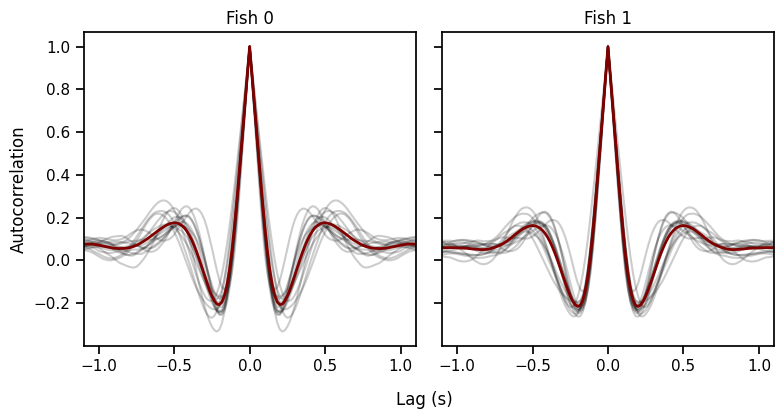

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
x_min, x_max = -1.1, 1.1

# plot fish 1 autocorrelation
acorrs = []
for g in range(len(df_list)):
    a_xs, acorr = velocity_time_lagged_autocorr(df_list[g], f_num=0)
    acorrs.append(acorr)
    ax1.plot(a_xs, acorr, color="black", alpha=0.2)

ax1.plot(a_xs, np.mean(acorrs, axis=0), color="maroon", lw=2)
ax1.set_xlim(x_min, x_max)
ax1.set_title("Fish 0")
ax1.set_ylabel("Autocorrelation")

# plot fish 0 autocorrelation
acorrs = []
for g in range(len(df_list)):
    a_xs, acorr = velocity_time_lagged_autocorr(df_list[g], f_num=1)
    acorrs.append(acorr)
    ax2.plot(a_xs, acorr, color="black", alpha=0.2)

ax2.plot(a_xs, np.mean(acorrs, axis=0), color="maroon", lw=2)
ax2.set_xlim(x_min, x_max)
ax2.set_title("Fish 1")
fig.text(0.54, -0.02, 'Lag (s)', ha='center', va='center', fontsize=12)

plt.tight_layout()

Next, plot the cross-correlation for the social states and the independent swimming sate

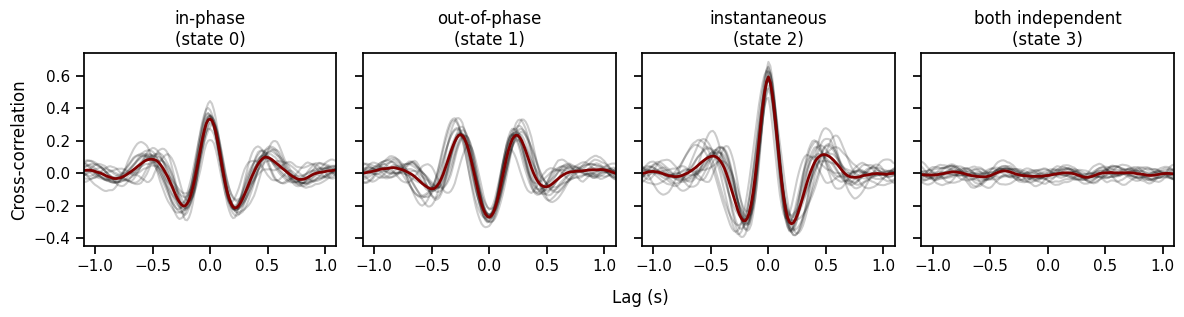

In [ ]:
# choose states to plot xcorr
xcorr_states_to_plot = [0, 1, 2, 3]
n = len(xcorr_states_to_plot)

fig, axes = plt.subplots(1, n, figsize=(3 * n, 3), sharex=True, sharey=True)
for i, ax in zip(xcorr_states_to_plot, axes):
    
    xcorrs = []
    for g in range(len(df_list)):
        x_xs, xcorr = velocity_time_lagged_xcorr(df_list[g], state=i, swap=True)
        mid = int((len(x_xs) + 1) / 2)
        n = 1000
        trunc_xs = x_xs[mid - n: mid + n + 1]
        trunc_xcorrs = xcorr[mid - n: mid + n + 1]
        xcorrs.append(trunc_xcorrs)
        ax.plot(trunc_xs, trunc_xcorrs, color="black", alpha=0.2)

    # plot mean xcorr
    ax.plot(trunc_xs, np.mean(xcorrs, axis=0), color="maroon", lw=2)
    
    # set plot properties
    ax.set_xlim(-1.1, 1.1)
    ax.set_title(state_names[i] + "\n" + f"(state {i})")
    if i == xcorr_states_to_plot[0]:
        ax.set_ylabel('Cross-correlation')  # only set ylabel for the first plot

fig.text(0.54, -0.02, 'Lag (s)', ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()


# __Step 4__: Plot phase response curves (PRCs) for synthetic data
____

## 4a. Identify start frames of hi/low sequences and record their durations

Because we swap the focal fish periodically between fish 0 & 1 when generating the synthetic data, we can plot the PRCs for two cases:
1. Choose fish 0 and fish 1 to be the focal and partner fish, respectively. This is what was done in the empirical data.
2. Use the true focal and partner fish

This will demonstrate how the instantaneous response state PRC fundamentally changes between cases. In the first case, it will look similar to the in-phase state. In the second, it will be obvious that the partner fish only responds to the focal. This suggest that in the empirical data, without perfect knowledge of which fish is the focal and which is the partner, we cannot currently determine if the in-phase swimming state is occuring due to the fish timing/preparing their bouts in advance or simply driven by an instantaneous response, or some combination of the two.


In [44]:
# get list of conditions
cs = synth_df["class"].unique().tolist()

# init lists to store start frame and durations of active sequences
fish0_hi_start_frames_by_class_group = [[] for _ in cs]
fish0_hi_durs_by_class_group = [[] for _ in cs]
fish1_hi_start_frames_by_class_group = [[] for _ in cs]
fish1_hi_durs_by_class_group = [[] for _ in cs]
# same, but now with perfect knowledge of the focal and partner fish
focal_hi_start_frames_by_class_group = [[] for _ in cs]
focal_hi_durs_by_class_group = [[] for _ in cs]
partner_hi_start_frames_by_class_group = [[] for _ in cs]
partner_hi_durs_by_class_group = [[] for _ in cs]

# init lists to store start frame and durations of inactive sequences
fish0_lo_start_frames_by_class_group = [[] for _ in cs]
fish0_lo_durs_by_class_group = [[] for _ in cs]
fish1_lo_start_frames_by_class_group = [[] for _ in cs]
fish1_lo_durs_by_class_group = [[] for _ in cs]
# same, but now with perfect knowledge of the focal and partner fish
focal_lo_start_frames_by_class_group = [[] for _ in cs]
focal_lo_durs_by_class_group = [[] for _ in cs]
partner_lo_start_frames_by_class_group = [[] for _ in cs]
partner_lo_durs_by_class_group = [[] for _ in cs]

# loop through synthetic conditions
for cond in cs:
    c_sel = (synth_df["class"]==cond)

    # loop through groups in condition
    for g in synth_df[c_sel]["group"].unique():

        # select group and get condition
        g_sel = (synth_df["group"] == g)

        # get bout sequences
        f0_bseq = synth_df[g_sel]["f0_bout_seq"].to_list()
        f1_bseq = synth_df[g_sel]["f1_bout_seq"].to_list()
        focal_bseq = synth_df[g_sel]["focal_bout_seq"].to_list()
        partner_bseq = synth_df[g_sel]["partner_bout_seq"].to_list()

        # get frames
        frames = synth_df[g_sel]["frame"].tolist()

        # get hi and lo start frames and durations
        f0_low_start_frames, f0_low_durations, f0_hi_start_frames, f0_hi_durations = analyze_subsequences(f0_bseq, frames)
        f1_low_start_frames, f1_low_durations, f1_hi_start_frames, f1_hi_durations = analyze_subsequences(f1_bseq, frames)
        focal_low_start_frames, focal_low_durations, focal_hi_start_frames, focal_hi_durations = analyze_subsequences(focal_bseq, frames)
        partner_low_start_frames, partner_low_durations, partner_hi_start_frames, partner_hi_durations = analyze_subsequences(partner_bseq, frames)

        # append to lists
        fish0_hi_start_frames_by_class_group[cond].append(f0_hi_start_frames)
        fish1_hi_start_frames_by_class_group[cond].append(f1_hi_start_frames)
        fish0_hi_durs_by_class_group[cond].append(f0_hi_durations)
        fish1_hi_durs_by_class_group[cond].append(f1_hi_durations)

        fish0_lo_start_frames_by_class_group[cond].append(f0_low_start_frames)
        fish1_lo_start_frames_by_class_group[cond].append(f1_low_start_frames)
        fish0_lo_durs_by_class_group[cond].append(f0_low_durations)
        fish1_lo_durs_by_class_group[cond].append(f1_low_durations)

        focal_hi_start_frames_by_class_group[cond].append(focal_hi_start_frames)
        partner_hi_start_frames_by_class_group[cond].append(partner_hi_start_frames)
        focal_hi_durs_by_class_group[cond].append(focal_hi_durations)
        partner_hi_durs_by_class_group[cond].append(partner_hi_durations)

        focal_lo_start_frames_by_class_group[cond].append(focal_low_start_frames)
        partner_lo_start_frames_by_class_group[cond].append(partner_low_start_frames)
        focal_lo_durs_by_class_group[cond].append(focal_low_durations)
        partner_lo_durs_by_class_group[cond].append(partner_low_durations)

## 4b. Get response lags of partner fish to focal fish bout and construct dataframe

First, lets package the useful information in a PRC dataframe using the code from step 2a.

In [45]:
state_type = "true_state"

# get dataframe with fish 0 as the focal fish
f0_foc_synth_PRC_df = get_prc_df_by_group_class(
    synth_df, 0,
    fish0_lo_start_frames_by_class_group, fish0_hi_start_frames_by_class_group, fish0_lo_durs_by_class_group, fish0_hi_durs_by_class_group,
    fish1_lo_start_frames_by_class_group, fish1_hi_start_frames_by_class_group, fish1_lo_durs_by_class_group, fish1_hi_durs_by_class_group,
    state_type
)

# get dataframe with fish 1 as the focal fish
f1_foc_synth_PRC_df = get_prc_df_by_group_class(
    synth_df, 1,
    fish1_lo_start_frames_by_class_group, fish1_hi_start_frames_by_class_group, fish1_lo_durs_by_class_group, fish1_hi_durs_by_class_group,
    fish0_lo_start_frames_by_class_group, fish0_hi_start_frames_by_class_group, fish0_lo_durs_by_class_group, fish0_hi_durs_by_class_group,
    state_type
)

# combine dataframes
synth_PRC_df = pd.concat([f0_foc_synth_PRC_df, f1_foc_synth_PRC_df])
synth_PRC_df = synth_PRC_df.reset_index(drop=True)

Next, slightly modify the code to construct a PRC dataframe that uses the true focal and partner fish.

In [46]:
def get_synth_prc_df(df, focal_hi_frames, partner_hi_frames, focal_low_frames, partner_low_frames, 
                     focal_hi_durs, partner_hi_durs, focal_low_durs, partner_low_durs, focal_fish_num_seq, verbose=False):
    """
    Construct data frame with the durations of active & inactive periods and the frames
    in which they begin for the true focal and partner fish. 
    """

    # init lists
    data = []

    # record number of bouts focal fish initiates that partner does not respond to
    focal_bouts_w_no_response = 0

    # get num of focal bouts
    n_bouts = len(focal_hi_frames)

    # get frames and states
    df_frames = df["frame"].values
    df_states = df["true_state"].values

    for i in range(n_bouts):
        # get true focal fish number from generated data
        true_focal_num = focal_fish_num_seq[i]

        focal_start = focal_hi_frames[i]
        focal_period_end = focal_hi_frames[i + 1] if i < n_bouts - 1 else np.inf

        valid_partner_bouts = [
                    (frame, partner_low_frames[idx], partner_hi_durs[idx], partner_low_durs[idx])
                for idx, frame in enumerate(partner_hi_frames)
            if focal_start <= frame < focal_period_end  # use "focal_start <= " to include 0-lag response
        ]

        if not valid_partner_bouts:
            #print(f"No valid partner bouts found for focal bout at frame {focal_start}.")
            focal_bouts_w_no_response += 1

        for j, (partner_hi_start, partner_low_start, p_hi_dur, p_low_dur) in enumerate(valid_partner_bouts):

            response_lag = partner_hi_start - focal_start
            is_first_response = (j == 0)

            focal_lo_start  = focal_low_frames[i] if i < len(focal_low_frames) else np.nan
            f_hi_dur = focal_hi_durs[i] if i < len(focal_hi_durs) else np.nan
            f_lo_dur = focal_low_durs[i] if i < len(focal_low_durs) else np.nan

            # select frames between start of focal fish active sequence and the 
            # end of the responding partners active sequence
            f_sel = (df_frames >= focal_start) & (df_frames <= (partner_hi_start + p_hi_dur))
            states = df_states[f_sel]

            # determine the state
            unique_states = np.unique(states)
            state = unique_states[0] if len(unique_states) == 1 else np.nan

            # get focal period
            f_period = f_hi_dur + f_lo_dur

            data.append([
                focal_start,
                f_hi_dur,
                focal_lo_start,
                f_lo_dur,
                partner_hi_start,
                p_hi_dur,
                partner_low_start,
                p_low_dur,
                response_lag,
                f_period,
                state,
                is_first_response,
                true_focal_num
            ])

    # create dataframe
    response_lags_df = pd.DataFrame(data, columns=[
        "focal_hi_start_frame", 
        "focal_hi_duration", 
        "focal_low_start_frame", 
        "focal_low_duration", 
        "partner_hi_start_frame", 
        "partner_hi_duration", 
        "partner_low_start_frame", 
        "partner_low_duration", 
        "partner_response_lag", 
        "focal_period",
        "true_state",
        "first_response",
        "true_focal_num"
    ])

    if verbose:
        print("partner did not respond to {} out of {} focal periods".format(focal_bouts_w_no_response, n_bouts))

    return response_lags_df


def get_synth_prc_df_by_group_class(
        bdf, 
        f_low_frames_by_class_group, f_hi_frames_by_class_group, f_low_durations_by_class_group, f_hi_durations_by_class_group, 
        p_low_frames_by_class_group, p_hi_frames_by_class_group, p_low_durations_by_class_group, p_hi_durations_by_class_group, 
        focal_fish_num_seq_by_group):
    
    df_list = []
    
    # loop through conditions
    for c, condition in enumerate(bdf["class"].unique()):
        c_sel = (bdf["class"] == condition)

        # loop through groups within condition
        for g, group in enumerate(bdf[c_sel]["group"].unique()):

            # select group
            g_sel = (bdf["group"] == group)
            
            # get true focal fish sequence
            focal_fish_num_seq = focal_fish_num_seq_by_group[g]
            
            # focal fish data
            f_low_frms_c_g = f_low_frames_by_class_group[c][g]
            f_low_durs_c_g = f_low_durations_by_class_group[c][g]
            f_hi_frms_c_g = f_hi_frames_by_class_group[c][g]
            f_hi_durs_c_g = f_hi_durations_by_class_group[c][g]

            # partner fish data
            p_low_frms_c_g = p_low_frames_by_class_group[c][g]
            p_low_durs_c_g = p_low_durations_by_class_group[c][g]
            p_hi_frms_c_g = p_hi_frames_by_class_group[c][g]
            p_hi_durs_c_g = p_hi_durations_by_class_group[c][g]

            # make df for group
            g_df = get_synth_prc_df(
                bdf[g_sel], 
                f_hi_frms_c_g, p_hi_frms_c_g, f_low_frms_c_g, p_low_frms_c_g,
                f_hi_durs_c_g, p_hi_durs_c_g, f_low_durs_c_g, p_low_durs_c_g, focal_fish_num_seq
            )

            # add columns: group, condition
            g_df["group"] = group
            g_df["class"] = condition

            # append to list
            df_list.append(g_df)

    return pd.concat(df_list)

In [47]:
# get dataframe
true_focal_synth_PRC_df = get_synth_prc_df_by_group_class(
    synth_df, 
    focal_lo_start_frames_by_class_group, focal_hi_start_frames_by_class_group, focal_lo_durs_by_class_group, focal_hi_durs_by_class_group,
    partner_lo_start_frames_by_class_group, partner_hi_start_frames_by_class_group, partner_lo_durs_by_class_group, partner_hi_durs_by_class_group,
    focal_fish_num_seq_by_group)


## 4c. Plot PRCs

In [50]:
def plot_PRC_heatmaps(PRC_df, num_states=n_states, state_type="state", x_max=60, y_max=60, 
                      suptitle=None, state_names=None, combine_nonsocial=True, 
                      fixed_cbar_lims=False, cmp="afmhot", FPS=FPS):
    
    if combine_nonsocial:
        num_states = 4

    # create grid
    x_range = np.arange(x_max + 1)  # bout timing difference
    y_range = np.arange(y_max + 1)  # focal fish period
    grid_x, grid_y = np.meshgrid(x_range, y_range)

    # get conditions to plot
    conds = PRC_df["class"].unique()
    n_conds = len(conds)

    # construct plot
    figsize = (3 * num_states, 3 * n_conds)
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(n_conds, num_states), axes_pad=0.4, 
                     cbar_location="right", cbar_mode="each", cbar_size="5%", cbar_pad=0.1)

    heatmaps_by_class_state = []
    for c, c_num in enumerate(conds):

        heatmaps_by_state = [[] for _ in range(num_states)]
        for s in range(num_states):
            # get plot index
            i = c * num_states + s

            # select class and state
            if combine_nonsocial & (s > 2):
                c_s_sel = (PRC_df["class"] == c_num) & (PRC_df[state_type].isin([3,4,5]))
            else:
                c_s_sel = (PRC_df["class"] == c_num) & (PRC_df[state_type] == s)

            # get periods and corresponding partner response lags
            f_periods = PRC_df[c_s_sel]["focal_period"].tolist()
            p_resp_lags = PRC_df[c_s_sel]["partner_response_lag"].tolist()

            # plot histogram
            heatmap, xedges, yedges = np.histogram2d(p_resp_lags, f_periods, bins=(x_range, y_range), density=False)
            heatmaps_by_state[s] = heatmap.T

            # set colorbar min and max and plot heatmap + colorbar
            if fixed_cbar_lims: 
                vmax = 0.004
            else: 
                max_color_percentile = 99.9
                vmax = np.percentile(heatmap, max_color_percentile)
            im = grid[i].imshow(heatmap.T, origin='lower', aspect='equal', cmap=cmp, vmin=0, vmax=vmax, extent=[0, x_max, 0, y_max])
            cbar = plt.colorbar(im, cax=grid.cbar_axes[i])

            # overlay y=x and y=2x lines
            grid[i].plot([0, x_max], [0, x_max], color='white', linestyle=':', linewidth=2, label='y=x')
            grid[i].plot([0, y_max/2], [0, y_max], color='white', linestyle='--', linewidth=2, label='y=2x')

            # display y_labels, y_ticks, and x_ticks only along the border of the plot
            if s == 0: 
                y_ticks = np.linspace(0, y_max, 3)
                y_labels = (y_ticks / FPS).round(2)  
                grid[i].set_yticks(y_ticks)
                grid[i].set_yticklabels(y_labels)

            if c == n_conds - 1:
                x_ticks = np.linspace(0, x_max, 3)
                x_labels = (x_ticks / FPS).round(2)
                grid[i].set_xticks(x_ticks)
                grid[i].set_xticklabels(x_labels)

            grid[i].set_ylim(0, y_max)
            grid[i].set_xlim(0, x_max)
            if state_names: grid[i].set_title(state_names[s])
            else: grid[i].set_title(f"state {s}")

        heatmaps_by_class_state.append(heatmaps_by_state)

    fig.add_subplot(111, frameon=False) 
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel('Partner response lag (s)', fontdict={'size': 12}, labelpad=0)
    plt.ylabel('Focal period (s)', fontdict={'size': 12}, labelpad=15)
    if suptitle:
        plt.suptitle(suptitle, size=12, x=0.5, y=1.04)
    plt.show()

In [ ]:
ate_names = [
    "in-phase\n(state 0)",
    "out-of-phase\n(state 1)",
    "instantaneous\n(state 2)",
    "non-social\n(states 3-5)",
]

Plot PRCs for case 1 where we fix fish 0 or 1 as the focal/partner fish. 

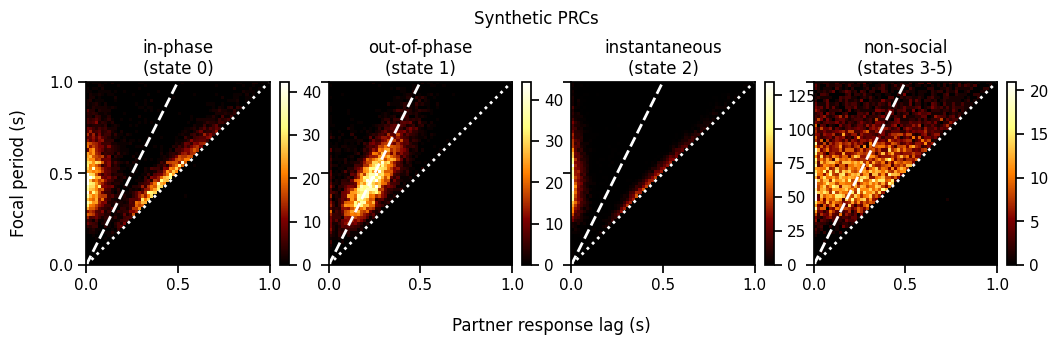

In [ ]:
suptitle = "Synthetic PRCs"
plot_PRC_heatmaps(synth_PRC_df, suptitle=suptitle, state_names=state_names, combine_nonsocial=True)

Next, plot PRCs for case 2 where we have perfect knowledge of the true focal and partner fish

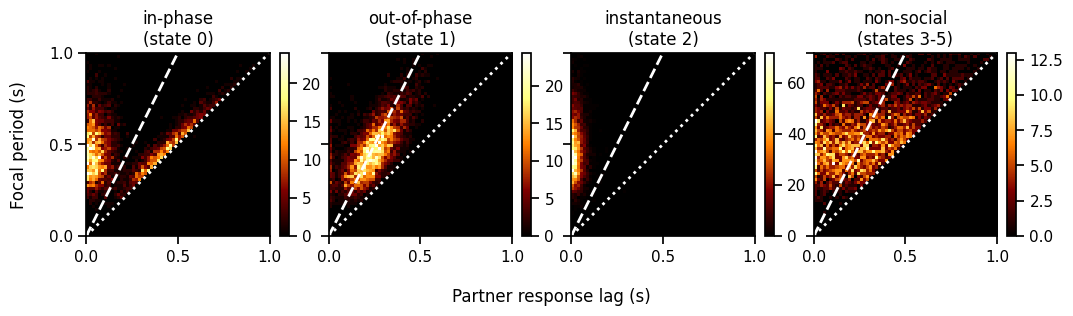

In [ ]:
state_type = "true_state"
suptitle = "Synthetic PRCs (true focal)"

plot_PRC_heatmaps(true_focal_synth_PRC_df, state_type=state_type, state_names=state_names, combine_nonsocial=True)
# plot_PRC_heatmaps(true_focal_synth_PRC_df, state_type=state_type, combine_nonsocial=False)

# __Step 5__: Fit randomly initialized model and examine best fit params
___

## 5a. Construct inputs & outputs for model fit

In [53]:
# function to denoise downsampled data
def denoise_ds(ipt_arr, obs_arr, ipt_lag, min_thr=0.1):
    if ipt_lag>0:
        ipt_arr = np.where(ipt_arr < min_thr, 0, ipt_arr)
        ipt_arr = np.where(ipt_arr > 1.0,     1, ipt_arr)
    obs_arr = np.where(obs_arr < min_thr, 0, obs_arr)
    obs_arr = np.where(obs_arr > 1.0,     1, obs_arr)
    return ipt_arr, obs_arr


def get_single_fish_ids_inputs_obs(df,f_num,q,lag,ipt_lag,denoise):
    # get time series that we will use to construct the inputs & outputs
    ipt_fish_num = -1*f_num + 1
    ipt_fish_bout_seq = np.array(df[f'f{ipt_fish_num}_bout_seq'].tolist(), dtype=int)
    obs_fish_bout_seq = np.array(df[f'f{f_num}_bout_seq'].tolist(), dtype=int)
    assert len(ipt_fish_bout_seq) == len(obs_fish_bout_seq)

    # discard frames that do not allow for full lag
    num_frames = len(ipt_fish_bout_seq)
    max_lag = max(lag, ipt_lag)
    valid_indices = np.arange(max_lag, num_frames - max_lag)

    # initialize inputs and outputs with NaNs
    inputs = np.full((num_frames, 2 * ipt_lag + 1), np.nan)
    obs = np.full((num_frames, 2 * lag + 1), np.nan)

    # construct symmetrically time-lagged inputs & outputs (vectorized for speed)
    if max_lag > 0:
        inputs[max_lag:-max_lag] = np.lib.stride_tricks.sliding_window_view(ipt_fish_bout_seq, 2*ipt_lag + 1)[valid_indices - ipt_lag]
        obs[max_lag:-max_lag] = np.lib.stride_tricks.sliding_window_view(obs_fish_bout_seq, 2*lag + 1)[valid_indices - lag]
    else:
        inputs = np.reshape(ipt_fish_bout_seq, (-1,1))
        obs = np.reshape(obs_fish_bout_seq, (-1,1))

    # downsample each input/output vector by factor 'q'
    if q > 1: 
        obs = signal.decimate(obs, q, n=8, ftype='iir') if lag > 0 else obs
        inputs = signal.decimate(inputs, q, n=8, ftype='iir') if ipt_lag > 0 else inputs

        #denoise and set floor/ceiling to 0/1
        if (denoise==True):
            inputs, obs = denoise_ds(inputs, obs, ipt_lag, min_thr=0.1)

    # make array to keep track of fish ids
    fish_id = np.full(num_frames, f_num, dtype=int)
    if max_lag > 0:
        frame_id = np.full(num_frames, np.nan)
        frame_id[max_lag:-max_lag] = valid_indices
    else:
        frame_id = valid_indices
    
    # concat input & fish ids
    f_ids = np.vstack((frame_id, fish_id)).T
    return f_ids, inputs, obs


def process_group(df, g, f_num, q, lag, ipt_lag, denoise):
    # get ids, ipts, obs
    g_sel = (df['group']==g)
    f_ids, inputs, obs = get_single_fish_ids_inputs_obs(df[g_sel], f_num, q, lag, ipt_lag, denoise)
    focal_fish = np.array(f_ids.T[1], dtype=int)

    # get group df
    g_df = df[g_sel].copy()
    g_df.insert(7, 'focal_fish', focal_fish)
    g_df.insert(8, 'input', np.round(inputs, 4).tolist())
    g_df.insert(9, 'output', np.round(obs, 4).tolist())
    
    valid_IO = ~np.isnan(inputs).any(axis=1)
    g_df.insert(10, 'valid_IO', valid_IO)

    return g_df.reset_index(drop=True), f_ids, inputs, obs


def get_group_data(df, gs, f_num, q, lag, ipt_lag, num_workers, denoise=True):
    df_list = []
    g_idxs, g_ipts, g_obs = [], [], []

    assert num_workers <= os.cpu_count()
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = executor.map(lambda g: process_group(df, g, f_num, q, lag, ipt_lag, denoise), gs)

    for result in results:
        g_df, f_ids, inputs, obs = result
        df_list.append(g_df)
        
        # append non-nan values to lists 
        mask = ~np.isnan(inputs).any(axis=1)
        g_idxs.append(f_ids[mask])
        g_ipts.append(inputs[mask])
        g_obs.append(obs[mask])

    return g_idxs, g_ipts, g_obs, pd.concat(df_list)


def get_data(df, gs, f_num, q, lag, ipt_lag, num_workers=1, denoise=True):
    # ensure valid focal fish numbers were passed
    assert f_num in [0, 1, 'both']

    # drop columns that may already present if the final analyzed
    # dataframe was loaded at the start of this notebook
    drop_cols = [
        'focal_fish', 'input', 'output', 'posts', 'thresh_state', 
        'state', 'local_posts', 'local_thresh_state', 'local_state', 'valid_IO']
    for col in drop_cols:
        if col in df.columns.values.tolist(): 
            df = df.drop(columns=[col])

    # print conditions, groups, and focal fish num(s)
    g_sel = df["group"].isin(gs)
    cs = df[g_sel]["class"].unique().tolist()
    f_nums = [f_num] if f_num != 'both' else [0, 1]
    print('Conditions:', cs)
    print('Groups: {}'.format(gs))
    print('Focal fish number(s): {}'.format(f_nums))

    # get group data
    bdfs, idxs, ipts, obs = [],[],[],[]
    for i, f in enumerate(f_nums):
        print('Constructing dataframe with fish {} as the focal fish...'.format(f))
        g_idxs, g_ipts, g_obs, bdf = get_group_data(df, gs, f, q, lag, ipt_lag, num_workers, denoise=denoise)
        idxs += g_idxs
        ipts += g_ipts
        obs += g_obs
        bdf["group"] = i*len(gs) + np.array(bdf["group"], dtype=int)
        bdfs.append(bdf)

    if f_num == 'both':
        print("Stacking dataframes...")
        
    bdfs = pd.concat(bdfs)
    cols_to_make_cat = ["focal_fish", "group"]
    bdfs[cols_to_make_cat] = bdfs[cols_to_make_cat].astype("category")
    print("Completed.")

    return bdfs, idxs, ipts, obs

In [54]:
q = 5           # downsample factor for input/output vectors (q = 5 recommended)
lag = 120       # frames to lag observations forward and backward (2 seconds recommended)
ipt_lag = lag   # frames to lag input forward and backward (2 seconds recommended)
f_num = "both"  # choose the focal fish num. Input fish num is -f_num + 1. Select 'both' to stack data from each fish, or choose 0 or 1 for a single fish
denoise = True  # clean up downsampled inputs & observations by setting floor of 0 and ceiling of 1

# select fish pairs (groups) to construct data from
groups = synth_df["group"].unique().tolist()  # select all groups across all conditiions

# optionally parallelize data construction (default = 1, recommend more for faster construction!)
num_workers = 10  

# get inputs, emissions (observations), and construct dataframe
bdf, g_idx, g_input, g_obs = get_data(synth_df, groups, f_num, q, lag, ipt_lag, num_workers, denoise=True)

# get new group numbers if stacking dataframes
if f_num == "both":
    groups = bdf["group"].unique().tolist()

Conditions: [0]
Groups: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Focal fish number(s): [0, 1]
Constructing dataframe with fish 0 as the focal fish...


Constructing dataframe with fish 1 as the focal fish...
Stacking dataframes...
Completed.


In [55]:
# concat group data and get dimensions
inputs = np.vstack(g_input)
emissions = np.vstack(g_obs)
input_dim = inputs.shape[-1]
emission_dim = emissions.shape[-1]

# optionally batch data into groups (recommended)
batches = True

num_batches = len(groups) if batches else 1
inputs = np.reshape(inputs, (num_batches, -1, input_dim))
emissions = np.reshape(emissions, (num_batches, -1, emission_dim))
num_timesteps = emissions.shape[1]

print('Input shape: ',inputs.shape)
print('Output shape:',emissions.shape)

Input shape:  (30, 53760, 49)
Output shape: (30, 53760, 49)


## 5b. Fit randomly initialized model

In [56]:
# specify whether to load params or not
Load = False

# set hyper params
num_states = 3       # num of latent states in model
symm_weights = True  # constrain toeplitz weights to be symmetric
N_iters = 20         # num of EM iterations
TOL = 1e-4           # convergence threshold of LL for early stopping

# select model params to fit
fit_params_dict = {"fit_initial_state_probs": True,
                   "fit_transition_matrix": True,
                   "fit_weights": True,
                   "fit_biases": True,
                   "fit_scales": True} 

  0%|          | 0/20 [00:00<?, ?it/s]

LL: -27561860.00   LL/samp: -17.09


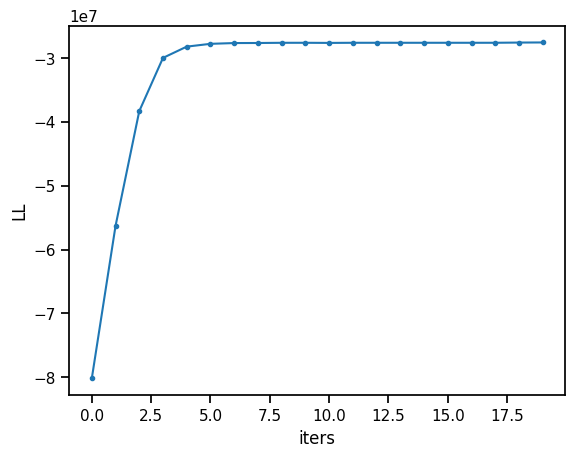

In [57]:
# instantiate model
hmm = ConstrainedLinearRegressionSharedSphericalGaussianHMM(
    num_states, 
    input_dim, 
    emission_dim, 
    symmetric=symm_weights, 
    transition_matrix_stickiness=0
)

# randomly initialize model params
keys = map(jr.PRNGKey, count()) 
init_params, param_props = hmm.initialize(key=next(keys), method="random")

# specify which model params will be fit
param_props.initial.probs.trainable                 = fit_params_dict["fit_initial_state_probs"]
param_props.transitions.transition_matrix.trainable = fit_params_dict["fit_transition_matrix"]
param_props.emissions.flat_weights.trainable        = fit_params_dict["fit_weights"]
param_props.emissions.biases.trainable              = fit_params_dict["fit_biases"]
param_props.emissions.scales.trainable              = fit_params_dict["fit_scales"]

# fit model and get training lls
fit_params, lls = hmm.fit_em_while(
    init_params, param_props, emissions, inputs=inputs, num_iters=N_iters, tolerance=TOL, verbose=True
)
lls_clean = lls[jnp.isfinite(lls)]

# plot training log likelihoods
print("LL: {:.2f}   LL/samp: {:.2f}".format(lls_clean[-1], lls_clean[-1] / (num_batches * num_timesteps)))
plt.plot(lls_clean,'.-')
plt.xlabel("iters")
plt.ylabel("LL")
plt.show()

## 5c. Plot observation model parameters

In [58]:
def plot_weights(weights, biases, lag, ipt_lag, num_states, FPS, define_lim=False, vmin=-0.06, vmax=0.18, 
                 display_bias=False,cmap="seismic", interp="spline16", figsize=(12,4)):
    
    if not define_lim: 
        vmin, vmax = np.min(weights), np.max(weights)

    # make assymetric seismic colormap using TwoSlopeNorm: vmin = blue, 0 = white, vmax = dark red
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # set plot params
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(1,num_states), axes_pad=0.25, cbar_location="right", cbar_mode="single", cbar_size="5%", cbar_pad=0.25)

    # plot
    for i in range(num_states):
        im = grid[i].imshow(weights[i],interpolation=interp,norm=norm,extent=[-lag/FPS,lag/FPS,-ipt_lag/FPS,ipt_lag/FPS],cmap=cmap)
        grid[i].set_xticks(np.linspace(-lag/FPS,lag/FPS,5))
        grid[i].set_yticks(np.linspace(-ipt_lag/FPS,ipt_lag/FPS,5))
        grid[i].set_xlabel('')
        grid[i].set_ylabel('Output Lag (s)',fontdict={'size':12})
        if i>0: plt.yticks([]); plt.ylabel('')
        if i==num_states-1: 
            cbar = plt.colorbar(im, cax=grid.cbar_axes[0])
            cbar.ax.set_yscale('linear')
        grid[i].set_title(r'$\mathbf{{W}}^{{({})}}$'.format(i))
        grid[i].spines['right'].set_visible(False)
        grid[i].spines['top'].set_visible(False)
        if display_bias:
            grid[i].text(x=0.65,y=1.65,s=r'$b^{{({})}} = {:.2f}$'.format(i,biases[i]))

    fig.add_subplot(111, frameon=False) 
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel('Input Lag (s)       ',fontdict={'size':12},labelpad=0)
    plt.show()

In [59]:
# optionally permute order of states
permute_states = True
if permute_states:
    perm = np.array([1,0,2])
    fit_params = hmm.permute(fit_params, perm)

# get best fit model params
tmat = fit_params.transitions.transition_matrix
init_prob = fit_params.initial.probs
flat_weights = fit_params.emissions.flat_weights
weights = hmm.emission_component.get_weights(flat_weights)
biases = fit_params.emissions.biases
scales = fit_params.emissions.scales

# package in dict
params = {"transition_matrix": np.array(tmat),
          "initial_probs": np.array(init_prob),
          "flat_weights": np.array(flat_weights),
          "weights": np.array(weights),
          "biases": np.array(biases),
          "scales": np.array(scales)
}

Scale: 0.343
Biases: 0.23, 0.32, 0.15


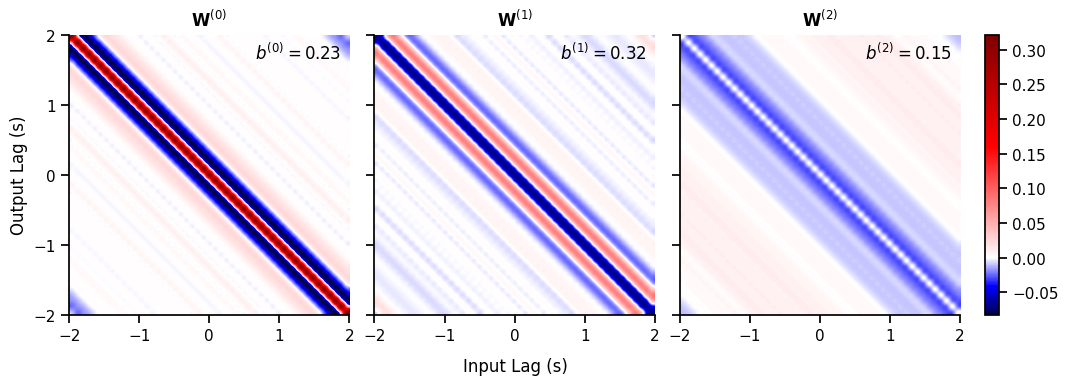

In [60]:
# print scale and biases
formatted_biases = [f"{b:.2f}" for b in params["biases"]]
print("Scale: {:.3f}".format(params["scales"][0]))
print(f"Biases: {', '.join(formatted_biases)}")

# choose colormap and interpolation for weights plot
cmp = "seismic"
interp = "spline16" # "none"

# optionally display biases on plots
display_bias = True

# plot weights
plot_weights(weights, biases, lag, ipt_lag, num_states, FPS, cmap=cmp, interp=interp, display_bias=display_bias)

Since the matrices are Toeplitz (have constant diagonals), a single slice is sufficient to capture most of the structure in the matrix.

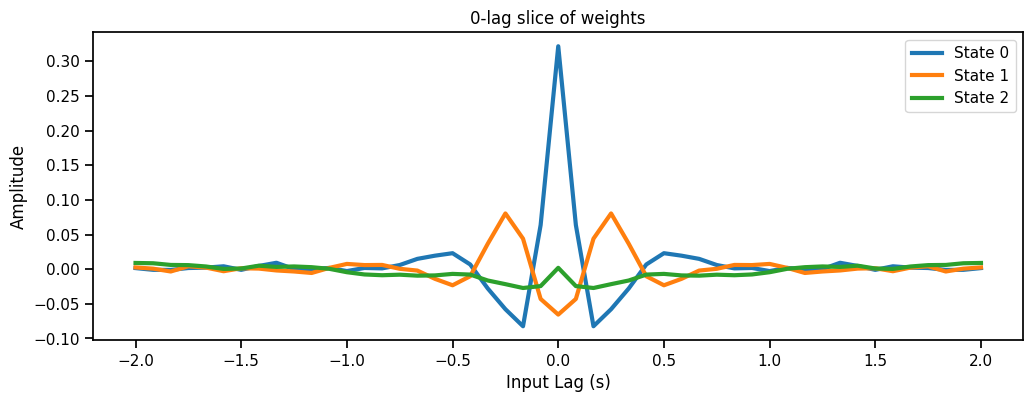

In [61]:
# get 0 lag slice
midpoint = int((emission_dim-1)/2)
wks_slice = params["weights"][:,midpoint,:]

# get x data in seconds
xs = np.linspace(-lag/FPS,lag/FPS,emission_dim)

# plot slices
figsize = (12,4)
fig = plt.figure(figsize=figsize)
for i in range(num_states):
    plt.plot(xs,wks_slice[i],'-',lw=3,label="State {}".format(i))
plt.xlabel("Input Lag (s)")
plt.ylabel("Amplitude")
plt.title("0-lag slice of weights")
plt.legend()
plt.show()

In summary, we created a synthetic dataset that closely mirrors real fish pair interactions. First, we decomposed the fish motion into binary pulses and observed that their high and low durations followed a log-normal distribution. Using these empirical distributions, we generated pulses for the synthetic fish. We then coupled the fish motions by assuming a relationship between the period of the focal fish $T$ and the response lag of the partner $\tau$: $T = m * \tau$ where $m$ is the state-dependent slope. The synthetic pulses replicated both the autocorrelation and the cross-correlation patterns observed in the real fish interactions. Finally, we fit the synthetic data to our model, revealing three distinct states that align with those identified in the empirical analysis.